# Implémentation et distribution sous Spark d'un algorithme d'apprentissage non-supervisé : k-means++

## Initialisation

Importation des librairies nécessaires et mise en place du contexte distribué Spark

In [1]:
from pyspark import SparkContext, SparkConf
from math import sqrt,log
from random import randint, random, randrange,uniform
from copy import deepcopy

import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

sc = SparkContext.getOrCreate()
sc.stop()

conf = SparkConf().setAppName("kmeans").setMaster("local[*]")
sc = SparkContext(conf=conf)

Récupération du jeu de données s1.txt, à partir des S-sets : https://cs.joensuu.fi/sipu/datasets/

In [2]:
s1 = sc.textFile("../data/s1.txt")

#Nous donnons une structure de liste particulière à notre jeu de données

def extract_split(x):
    splits = x.split('    ')
    return (int(splits[1]), int(splits[2]))

s1 = s1.flatMap(lambda x: x.split('\n')).map(extract_split)

s1 = s1.sample(withReplacement=False,fraction=0.5)

In [3]:
#Pour visualiser cette structure particulière

s1.takeSample(False, 20)

[(381617, 157000),
 (681941, 370225),
 (843432, 490725),
 (528011, 201615),
 (627968, 574625),
 (824475, 518063),
 (398311, 383357),
 (412677, 786951),
 (838367, 536676),
 (540364, 163758),
 (801177, 737548),
 (533775, 163036),
 (587478, 424878),
 (376613, 159699),
 (474641, 81263),
 (628715, 434772),
 (608923, 385575),
 (749723, 781756),
 (560393, 389490),
 (690018, 819280)]

# Initialisation de l'algorithme k-means++


## compute_distance 

Nous définissons la fonction compute_distance, qui sera utilisée dans un map pour calculer la distance euclidienne entre un point et un centre de cluster à partir des numéros de colonnes du points et du centre de cluster.

In [4]:
#Nous ajoutons une nouvelle colonne qui répertoriera les distances entre chaque point et chaque centre.

def compute_distance(xi_indexes, yi_indexes):
    def map(row):
        sum = 0
        for i in range(len(xi_indexes)):
            sum += (row[yi_indexes[i]] - row[xi_indexes[i]]) ** 2
        distance = sqrt(sum)
        return row + (distance,)
    return map

## Description de l'algorithme 

L'algorithme k-means++ demande de tirer un premier centre de manière uniformément aléatoire parmi l'ensemble des points de données. Pour le reste des centres, il faudra :

- calculer la distance entre chaque point xi et le centre de cluster déjà établi le plus proche

- associer à chaque point xi une probabilité proportionnelle au carré de cette distance (normalisée de façon à avoir la somme des probabilités pour chaque point égale à 1)

- tirer un nouveau centre en utilisant le vecteur de probabilité calculé à l'étape précédente

- réitérer les étapes 2 et 3 jusqu'à ce que k centres aient été choisis

On peut ensuite effectuer un kmeans classique où l'on va successivement calculer les barycentres de chaque cluster et ré-assigner les points dans chaque cluster jusqu'à convergence.

Malheureusement, cette approche probabiliste de kmeans++ pose problème dans le cadre distribué.

En effet, si l'on veut tirer un nouveau centre en utilisant le vecteur de probabilités de façon rigoureuse, il faut forcément itérer sur chacun des points pour trouver le point selectionné par notre tirage aléatoire.

On a ainsi implémenté à la fois cette version qui n'est pas complétement distribuée, mais l'on a aussi choisit d'utiliser d'autres stratégies d'initialisation.

## 1ère stratégie : le maximum

Admettons que nous ayons n centres déjà établis. Pour choisir le (n+1)ème centre, nous allons observer les distances de chaque point xi (qui n'est pas un centre déjà établi) aux centres déjà établis. 

Pour un point donné xi, nous prenons la distance minimale à un centre déjà établi (autrement dit le centre déjà établi le plus proche de xi).

Nous prenons comme (n+1)ème centre le xi qui est le plus éloigné de son centre (déjà établi) le plus proche.

Cette approche est implémenté dans le reduce suivant :

In [5]:
def reduceMax(dist_indexes):
    def reduce_custom(x1,x2):
        '''
        print("\n")
        '''
        dist_x1 = []
        dist_x2 = []
        for idx in dist_indexes:
            dist_x1.append(x1[idx])
            dist_x2.append(x2[idx])
        
        '''
        print("------")
        
        print("X1 :", x1[0], x1[1])
        print("Dist x1 : ",dist_x1)
        '''
        mindist_x1 =  min(dist_x1)
        
        '''
        print("Min dist x1 :", mindist_x1)
        
        print("X2 :", x2[0], x2[1])
        print("Dist x2 : ", dist_x2)
        '''
        mindist_x2 = min(dist_x2)
        '''
        print("Min dist x2 :", mindist_x2)
        print("------")
        '''
        
        
        result = None
        if(mindist_x1 > mindist_x2):
            result = x1
        else:
            result = x2
        
        '''
        print("Result :", result[0], result[1])
        
        '''
        return result
        
        
    return reduce_custom

## 2ème stratégie : La somme des distances

Admettons que nous ayons n centres déjà établis.

Pour choisir le (n+1)ème centre, nous allons observer les distances de chaque point xi (qui n'est pas un centre déjà établi) aux centres déjà établis. 

Pour un point donné xi, nous sommons ses distances aux n centres déjà établis.

Nous prenons comme (n+1)ème centre le xi dont la somme de ses distances aux n centres déjà établis est la plus grande.

In [6]:
def reduceMaxSum(dist_indexes):
    def reduce_custom(x1,x2):
        dist_x1 = []
        dist_x2 = []
        for idx in dist_indexes:
            dist_x1.append(x1[idx])
            dist_x2.append(x2[idx])
        
        mindist_x1 =  sum(dist_x1)
        mindist_x2 = sum(dist_x2)
        
        
        if(mindist_x1 > mindist_x2):
            return x1
        else:
            return x2
        
        
    return reduce_custom

## 3ème stratégie : La moyenne des distances

Il s'agit de faire la même chose que pour la 2ème stratégie, sauf que pour chaque xi, la somme de ses distances aux n centres déjà établis sera pondérée par l'inverse du nombre de distances calculées pour xi (on calcule ainsi la moyenne des distances aux différents clusters).

In [7]:
def reduceMaxAverage(dist_indexes):
    def reduce_custom(x1,x2):
        dist_x1 = []
        dist_x2 = []
        for idx in dist_indexes:
            dist_x1.append(x1[idx])
            dist_x2.append(x2[idx])
        
        mindist_x1 =  sum(dist_x1)/len(dist_x1)
        mindist_x2 = sum(dist_x2)/len(dist_x2)
        
        
        if(mindist_x1 > mindist_x2):
            return x1
        else:
            return x2
        
        
    return reduce_custom

## 4ème stratégie : kmeans++ non optimisé pour la distribution

On a ici implémenté l'initialisation probabiliste de kmeans++.

In [8]:
def mapDistance(dist_indexes):
    def custom_map(row):
        index = row[0]
        table = row[1]
        dists = []
        for idx in dist_indexes:
            dists.append(table[idx])

        min_dist = min(dists)

        return (index, min_dist)
    return custom_map

def basicMaxReduce(x1,x2):
    return max(x1,x2)


def findNextCenter(data, dist_indexes, coord_indexes):
    dataZip = data.zipWithIndex().map(lambda x : (x[1],x[0]))
    print ("Data zip", dataZip.take(3))
    
    #Map Min Dist
    dataZipMap = dataZip.map(mapDistance(dist_indexes))
    print ("Data zip map", dataZipMap.take(3))

    #Normalize distance
    nc = dataZipMap.map(lambda x: x[1])
    
    print ("Data to extract max dist", nc.take(3))
    
    nc = nc.reduce(lambda a,b:a+b)
    
    
    print("Full cumulative sum is  : ", nc)
    
    dataZipMap = dataZipMap.map(lambda x: (x[0], x[1]/nc) )
    
    print("Data zip map normalized ", dataZipMap.take(3))
    
    collection = dataZipMap.collect()
    print(collection[:3])
    
    #Draw best point
    indexes = [item[0] for item in collection]
    prob = [item[1] for item in collection]
    
    print(indexes[:3])
    print(prob[:3])
    print(sum(prob))
    
    cumsum = np.cumsum(prob)
    
    index_best_point = None
    
    draw = uniform(0,1)
    print("Draw : ", draw)
    print("Cumsum 0", cumsum[0])
    if(draw < cumsum[0]):
        index_best_point = indexes[0]
    else:
        current_index = 1
        current_sum = cumsum[current_index]
        previous_sum = cumsum[current_index -1]
        while not(draw < current_sum and draw >= previous_sum):
            #print("Index loop ", current_index)
            #print("Current sum ", current_sum)
            #print("Previous sum", previous_sum)
            
            current_index += 1
            previous_sum = cumsum[current_index -1]
            current_sum = cumsum[current_index]
            
        index_best_point = current_index
    
    best_point = dataZip.filter(lambda x: x[0] == index_best_point).collect()
    print("Best point ", best_point)
    result = tuple([best_point[0][1][coord] for coord in coord_indexes])
    print(result)
    return result

## 5ème stratégie : pseudo kmeans++ distribué

Ici on a effectué une tentative de distribution de kmeans++.

Pour choisir le point qui sera selectionné comme prochain centre de cluster, on effectue des comparaisons successives entre les points. Cela ressemble à une sorte de tournoi.

Nous avons deux points avec pour chacun  d'entre eux, la distance à leur cluster le plus proche, notées d1 et d2. Nous tirons une loi uniforme sur le compact [0;d1+d2]. Notre règle de décision est la suivante : nous choisissons X1 si U < D1, et nous choisissons X2 sinon. Ainsi, nous réalisons des tournois 1 contre 1 (un tournoi entre deux points), ce qui nous donne de multiples réalisations de lois uniformes en 1 contre 1.

Par exemple si l'on a X1 a une distance de 2 de son plus proche cluster, X2 a une distance de 5, et X3 a une distance de 6.

L'algorithme va  :
- Choisir entre X1 et X2 en tirant à partir d'un tirage uniforme ou X1 à un poids de 2 et X2 un poids de 5
- Supposons que X2 ai gagné le précédent tirage, l'algorithme va ensuite choisir entre X2 et X3, où X2 à un poids de 5 et X3 un poids de 6.

On obtient ainsi le prochain cluster.

Cet algorithme a donné de mauvais résultats, qui s'expliquent surement sur la façon dont est effectué le reduce ou bien par un problème dans le code.



In [9]:
def reduceMaxWithRandom(dist_indexes):
    def reduce_custom(x1,x2):
        dist_x1 = []
        dist_x2 = []
        for idx in dist_indexes:
            dist_x1.append(x1[idx])
            dist_x2.append(x2[idx])
        
        mindist_x1 =  min(dist_x1)
        mindist_x2 = min(dist_x2)
        
        
        draw = uniform(0,mindist_x1 + mindist_x2)    
        
        '''
        print("\n")
        print("X1 :", x1[0], x1[1])
        print("X2 :", x2[0], x2[1])
        
        print("Min_dist x1 :", mindist_x1)
        print("Min_dist x2 :", mindist_x2)
        print("Draw : ", draw)
        '''
        result = x1
        if(draw > mindist_x1):
            result = x2
            
        #print ("Result : ",result[0], result[1])
        return result
        
            
    return reduce_custom

## 6ème stratégie :

Même stratégie que la 5ème, sauf que le poids de X1 ou X2 n'est pas lié à la distance mininmale au centre de cluster le plus proche mais à la somme de ses distances avec les différents centres de cluster.

In [10]:
def reduceMaxWithRandomSum(dist_indexes):
    def reduce_custom(x1,x2):
        dist_x1 = []
        dist_x2 = []
        for idx in dist_indexes:
            dist_x1.append(x1[idx])
            dist_x2.append(x2[idx])
        
        mindist_x1 =  sum(dist_x1)
        mindist_x2 = sum(dist_x2)
        
        
        draw = uniform(0,mindist_x1 + mindist_x2)    
            
        result = x1
        if(draw > mindist_x1):
            result = x2
        return result
        
            
    return reduce_custom

Les trois algorithmes qui suivent seront utilisé pour effectuer le kmeans classique (calcul des barycentres et mise à jour des distances/centre de clusters)

### Réajustement des centres : calculs des barycentres de chaque cluster

In [11]:
def compute_average(list_reduce, coord_indexes):
    result = ()
    for idx in coord_indexes:
        coord_list = [reduce_tuple[1][idx] for reduce_tuple in list_reduce]
        average = sum(coord_list)/len(coord_list)
        result += (average,)
    return result

### Représentation graphique des clusters

In [12]:
def drawGraph(data, cluster_centers):
    datalist = data.collect()
    plt.figure()
    x = [point[0] for point in datalist]
    y = [point[1] for point in datalist]
    
    x_clusters = [point[0] for point in cluster_centers]
    y_clusters = [point[1] for point in cluster_centers]
    
    plt.plot(x,y,'bs', x_clusters, y_clusters, 'r^')

### Map pour effectuer une copie d'un tuple et l'ajouter à une ligne

In [13]:
def mapAddTuple(t, coord_idx):
    def map(row):
        
        toAdd = tuple([deepcopy(t[i]) for i in coord_idx])
        
        return row + toAdd
    return map

# Algorithme d'initialisation kmeans++ incluant les algorithmes précédents

In [14]:
def initCluster(data,num_clusters,num_features, reducer, cluster_centers, visualize=False, distributed = True):
    xi_indexes = [idx for idx in range(0,num_features)]
    yi_indexes = [idx for idx in range(num_features, num_features*2)]
    coord_indexes = [idx for idx in range(num_features)]
    dist_indexes = [num_features*2]
    current_clust = 2
    
    '''
    print("Initial xi_indexes : ", xi_indexes)
    print("Initial yi_indexes : ", yi_indexes)
    print("Initial coord_indexes : ",coord_indexes)
    print("Initial dist_indexes : ", dist_indexes)
    print("Intial current_clust :", current_clust)
    print("\n")
    '''
    
    for _ in range(num_clusters-1):
        
        #print("#############################")
        
        
        print("Current cluster points :", cluster_centers)
        '''
        print("Data before adding distance")
        collect = data.collect()
        for line in data.collect():
            print(line, "\n")
        '''
        
        data_dist = data.map(compute_distance(xi_indexes, yi_indexes))
        
        
        
        
        if not distributed:
            new_cluster_point = findNextCenter(coord_indexes=coord_indexes,data=data_dist,dist_indexes=dist_indexes)
        else:
            '''
            print("\n Data with distance")
            for line in data_dist.collect():
                print(line, "\n")

            '''
            reduce_tuple = data_dist.reduce(reducer(dist_indexes=dist_indexes))

            ''' 
            print("\n Data after reduce")
            for line in data_dist.collect():
                print(line, "\n")
            '''
        
        
            new_cluster_point = tuple(reduce_tuple[i] for i in coord_indexes)
            
        cluster_centers.append(new_cluster_point)
        
        
        print("\n Cluster list : ", cluster_centers)
                                  
        #print("Computing center of cluster n° {}".format(current_clust))
        print("\n New cluster point : {}".format(new_cluster_point))
        
        
        
        
#CE MAP ETAIT LA SOURCE DES SOUCI : EN EFFET, NOUS NOUS RETROUVIONS AVEC DES NOUVEAUX CENTRES QUI ECRASAIENT LES
#ANCIENS DANS LE MAP, ET C'EST POUR CELA QUE NOUS NOUS RETROUVIONS AVEC UN NOMBRE DE CENTRES REDUIT (ET DE NOMBREUX
#CENTRES IDENTIQUES) A L'ARRIVEE. AINSI, POUR PALLIER CE PROBLEME, NOUS AVONS ENCAPSULE LE CODE DANS UNE FONCTION.
        
        data_point = data_dist.map(mapAddTuple(new_cluster_point,coord_idx=coord_indexes))
        
        data = data_point
        
        data_point.count()
        
        '''
        print("\n Data after adding new cluster point")
        for line in data_point.collect():
            print(line, "\n")
        '''
        
        if visualize:
            #Assume that data is 2D, and coord is 0,1
            drawGraph(data, cluster_centers)
        
        #Update of variables
        current_clust += 1
        dist_indexes.append(current_clust*num_features + current_clust - 2)
        yi_indexes = [old_value + num_features + 1 for old_value in yi_indexes]
        
        #print("New yi indexes : {}".format(yi_indexes))
        #print("New dist_indexes : {}".format(dist_indexes))
        
        '''
        print("\n")
        print("##############################")
        '''
    return data, cluster_centers

# Exemple d'utilisation de l'algorithme k-means++ sur nos données (version non distribuée)

Initial cluster center :  (414014, 816460) 

Current cluster points : [(414014, 816460)]
Data zip [(0, (665845, 557965, 414014, 816460, 360885.7403472739)), (1, (597173, 575538, 414014, 816460, 302639.43788772804)), (2, (618600, 551446, 414014, 816460, 334795.2383054454))]
Data zip map [(0, 360885.7403472739), (1, 302639.43788772804), (2, 334795.2383054454)]
Data to extract max dist [360885.7403472739, 302639.43788772804, 334795.2383054454]
Full cumulative sum is  :  1071218004.2499722
Data zip map normalized  [(0, 0.00033689290033913586), (1, 0.0002825189986417612), (2, 0.00031253697844619107)]
[(0, 0.00033689290033913586), (1, 0.0002825189986417612), (2, 0.00031253697844619107)]
[0, 1, 2]
[0.00033689290033913586, 0.0002825189986417612, 0.00031253697844619107]
1.0000000000000002
Draw :  0.9837673434397671
Cumsum 0 0.000336892900339
Best point  [(2387, (640000, 863831, 414014, 816460, 230897.56134918358))]
(640000, 863831)

 Cluster list :  [(414014, 816460), (640000, 863831)]

 New cl

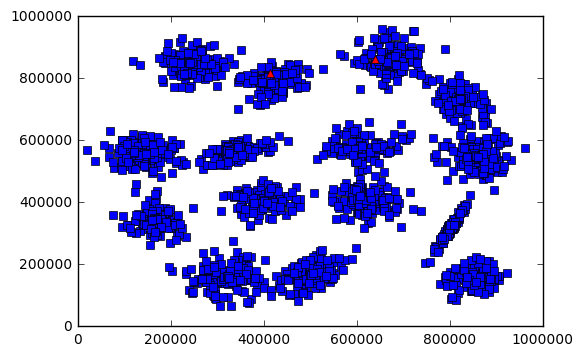

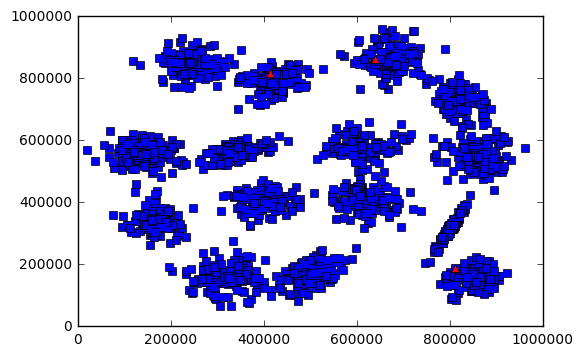

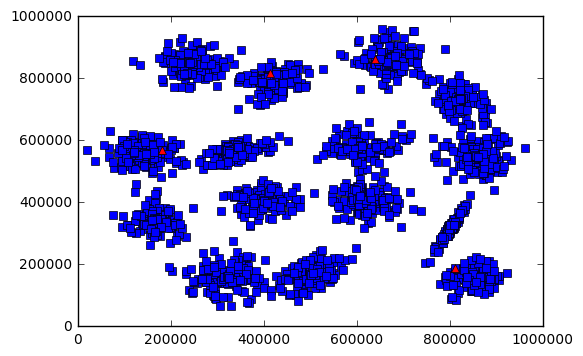

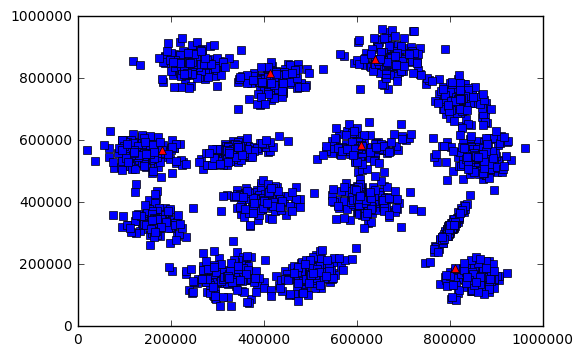

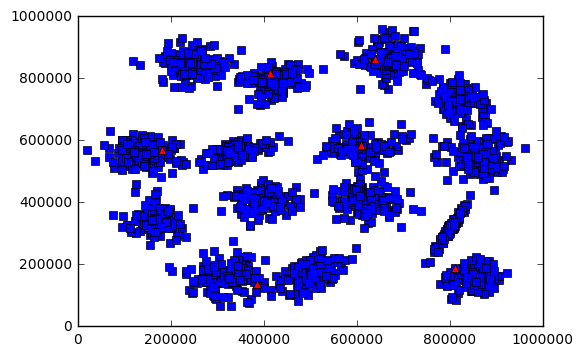

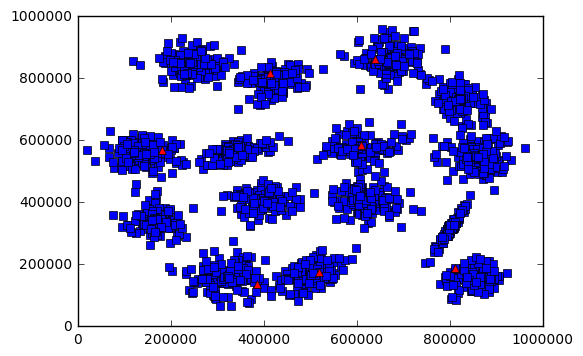

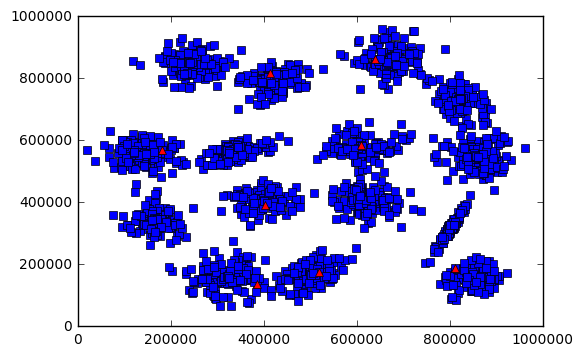

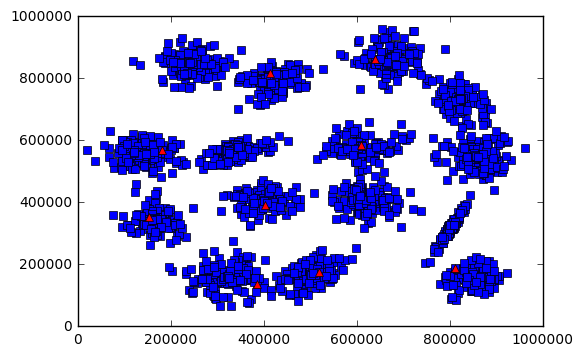

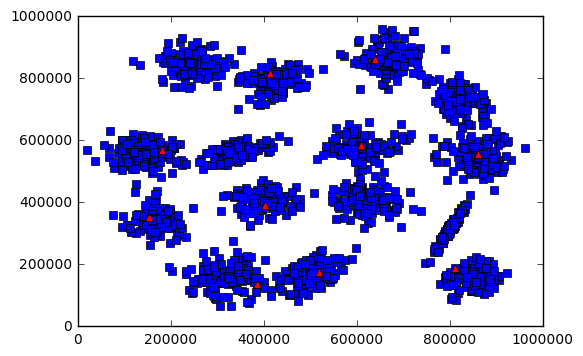

In [15]:
cluster1_center = s1.takeSample(False, 1)[0]
cluster_centers = [cluster1_center]
print("Initial cluster center : ",cluster1_center, "\n")
s1_map = s1.map(lambda x : x + cluster1_center)
s1_map_clustered, cluster_centers = initCluster(s1_map, num_features=2,num_clusters=10, reducer=reduceMax, cluster_centers=cluster_centers, visualize=True, distributed=False)


print(cluster_centers)

# Exemple d'utilisation de l'algorithme k-means++ sur nos données (stratégie reduceMax)

Initial cluster center :  (459328, 805961) 

Current cluster points : [(459328, 805961)]

 Cluster list :  [(459328, 805961), (874672, 104851)]

 New cluster point : (874672, 104851)
Current cluster points : [(459328, 805961), (874672, 104851)]

 Cluster list :  [(459328, 805961), (874672, 104851), (202627, 179376)]

 New cluster point : (202627, 179376)
Current cluster points : [(459328, 805961), (874672, 104851), (202627, 179376)]

 Cluster list :  [(459328, 805961), (874672, 104851), (202627, 179376), (916704, 609548)]

 New cluster point : (916704, 609548)
Current cluster points : [(459328, 805961), (874672, 104851), (202627, 179376), (916704, 609548)]

 Cluster list :  [(459328, 805961), (874672, 104851), (202627, 179376), (916704, 609548), (56907, 586609)]

 New cluster point : (56907, 586609)
Current cluster points : [(459328, 805961), (874672, 104851), (202627, 179376), (916704, 609548), (56907, 586609)]

 Cluster list :  [(459328, 805961), (874672, 104851), (202627, 179376), (

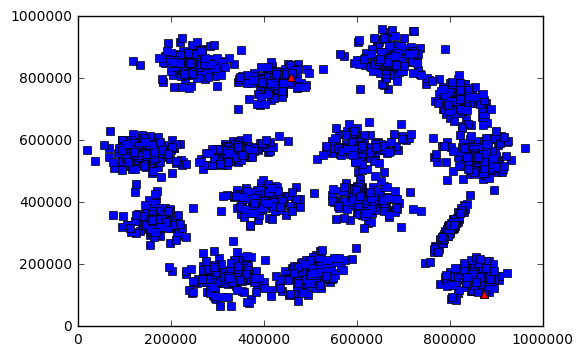

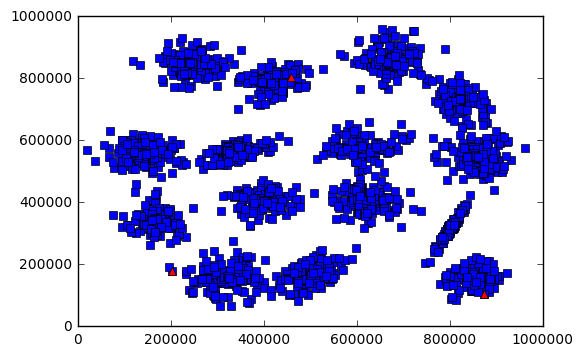

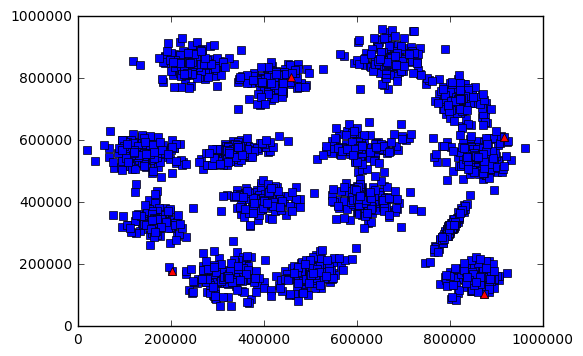

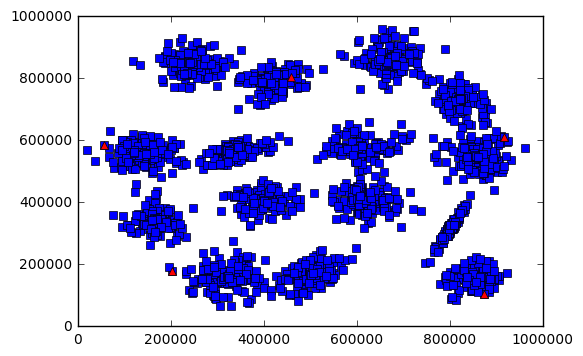

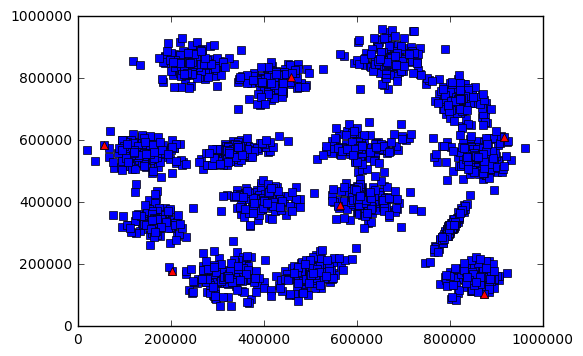

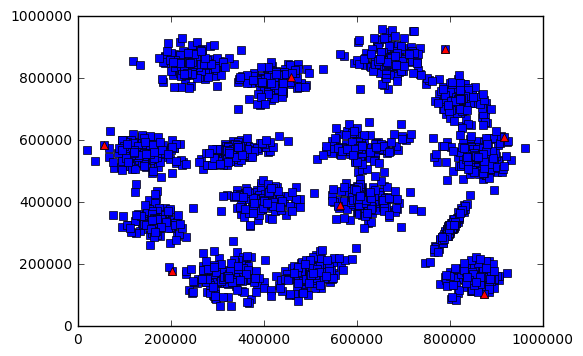

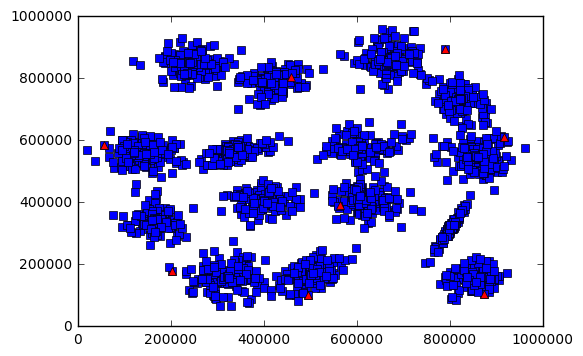

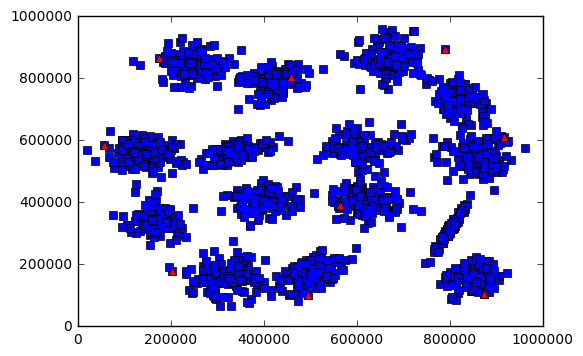

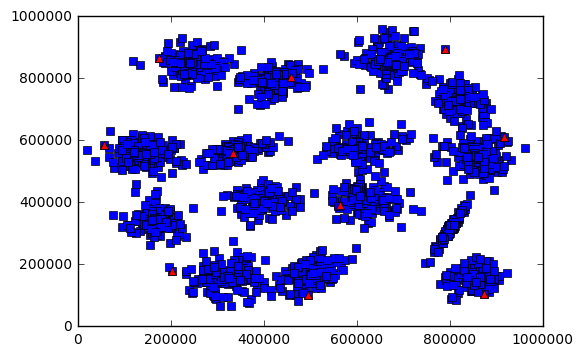

In [16]:
cluster1_center = s1.takeSample(False, 1)[0]
cluster_centers = [cluster1_center]
print("Initial cluster center : ",cluster1_center, "\n")
s1_map = s1.map(lambda x : x + cluster1_center)
s1_map_clustered, cluster_centers = initCluster(s1_map, num_features=2,num_clusters=10, reducer=reduceMax, cluster_centers=cluster_centers, visualize=True)


print(cluster_centers)

# Exemple d'utilisation de l'algorithme k-means++ sur nos données (stratégie reduceMaxWithRandom)

Initial cluster center :  (459328, 805961) 

Current cluster points : [(459328, 805961)]

 Cluster list :  [(459328, 805961), (618053, 357534)]

 New cluster point : (618053, 357534)
Current cluster points : [(459328, 805961), (618053, 357534)]

 Cluster list :  [(459328, 805961), (618053, 357534), (684091, 842566)]

 New cluster point : (684091, 842566)
Current cluster points : [(459328, 805961), (618053, 357534), (684091, 842566)]

 Cluster list :  [(459328, 805961), (618053, 357534), (684091, 842566), (605891, 428146)]

 New cluster point : (605891, 428146)
Current cluster points : [(459328, 805961), (618053, 357534), (684091, 842566), (605891, 428146)]

 Cluster list :  [(459328, 805961), (618053, 357534), (684091, 842566), (605891, 428146), (659046, 930099)]

 New cluster point : (659046, 930099)
Current cluster points : [(459328, 805961), (618053, 357534), (684091, 842566), (605891, 428146), (659046, 930099)]

 Cluster list :  [(459328, 805961), (618053, 357534), (684091, 842566)

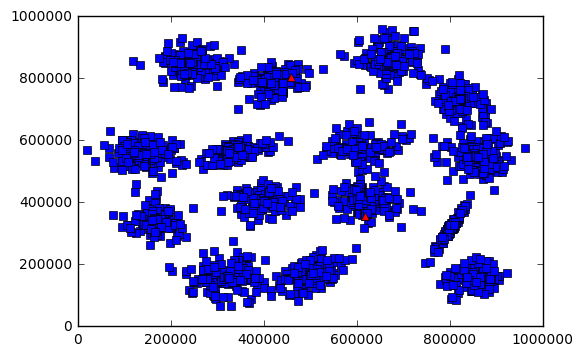

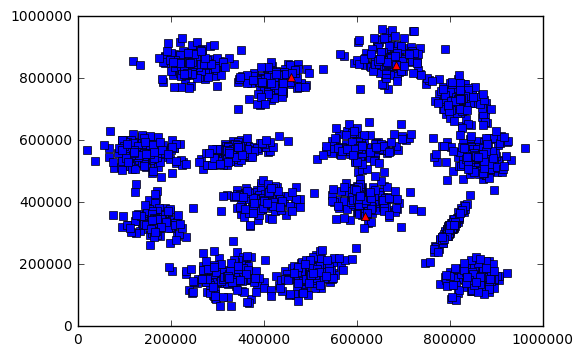

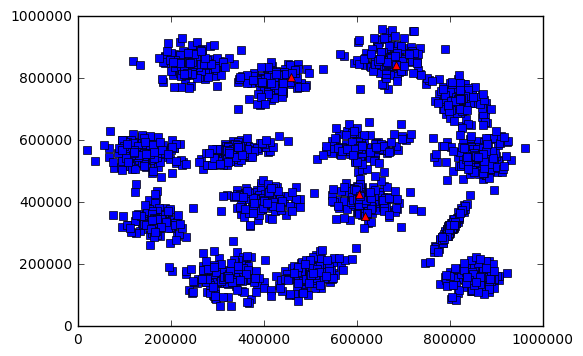

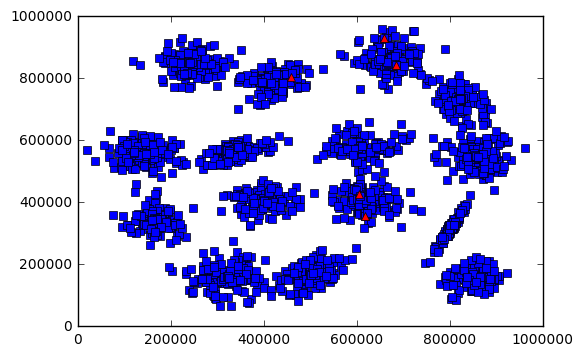

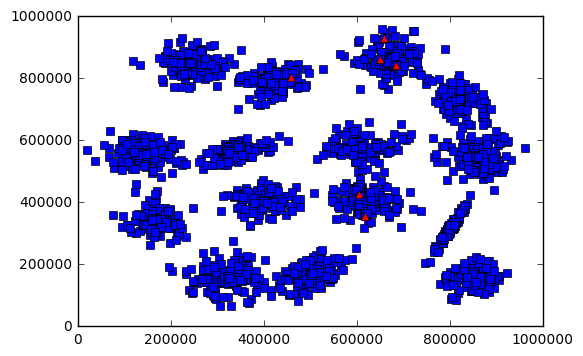

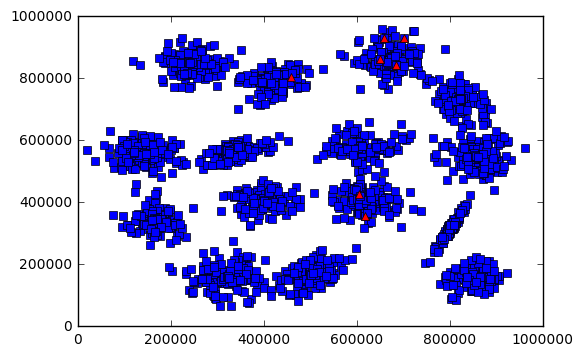

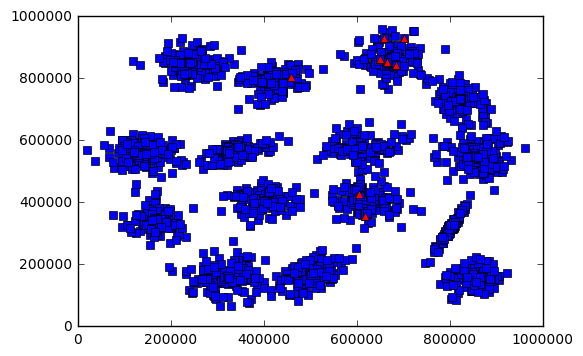

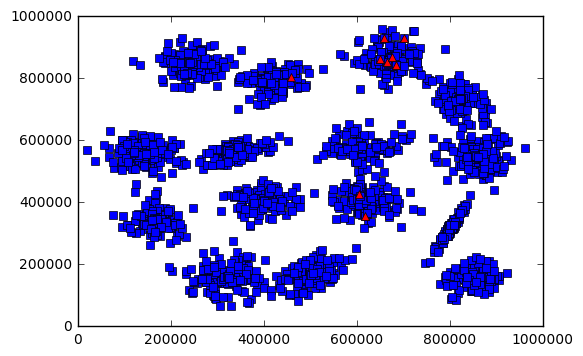

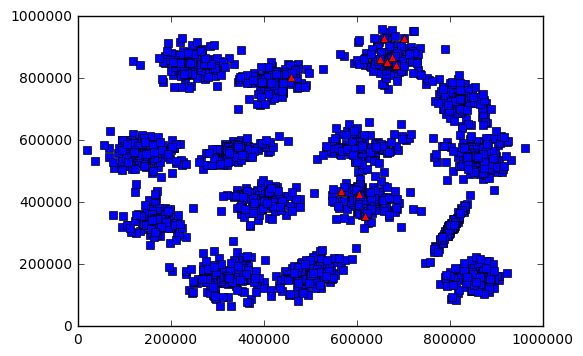

In [17]:
print("Initial cluster center : ",cluster1_center, "\n")
cluster_centers = [cluster1_center]
s1_map_clustered2 = initCluster(s1_map, num_features=2,num_clusters=10, reducer=reduceMaxWithRandom,  cluster_centers=cluster_centers, visualize=True)

# Exemple d'utilisation de l'algorithme k-means++ sur nos données (version distribuée et initialisation reduceMaxSum)

Initial cluster center :  (459328, 805961) 

Current cluster points : [(459328, 805961)]

 Cluster list :  [(459328, 805961), (874672, 104851)]

 New cluster point : (874672, 104851)
Current cluster points : [(459328, 805961), (874672, 104851)]

 Cluster list :  [(459328, 805961), (874672, 104851), (19835, 570290)]

 New cluster point : (19835, 570290)
Current cluster points : [(459328, 805961), (874672, 104851), (19835, 570290)]

 Cluster list :  [(459328, 805961), (874672, 104851), (19835, 570290), (961951, 577029)]

 New cluster point : (961951, 577029)
Current cluster points : [(459328, 805961), (874672, 104851), (19835, 570290), (961951, 577029)]

 Cluster list :  [(459328, 805961), (874672, 104851), (19835, 570290), (961951, 577029), (306042, 66361)]

 New cluster point : (306042, 66361)
Current cluster points : [(459328, 805961), (874672, 104851), (19835, 570290), (961951, 577029), (306042, 66361)]

 Cluster list :  [(459328, 805961), (874672, 104851), (19835, 570290), (961951, 

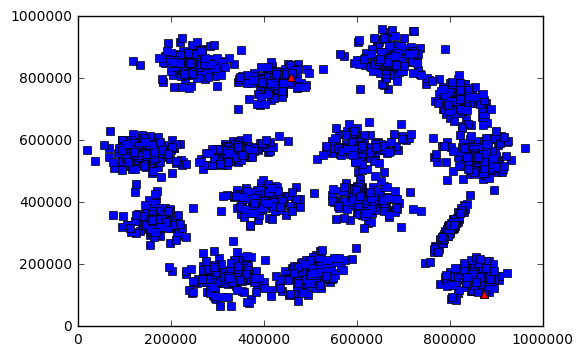

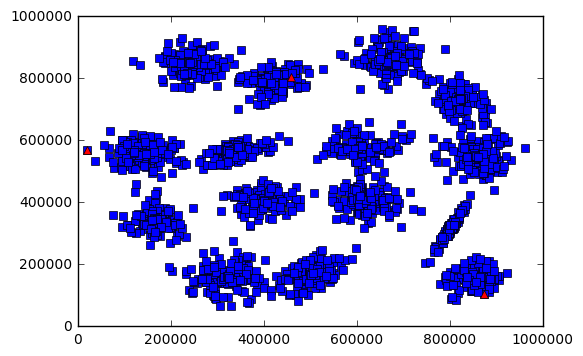

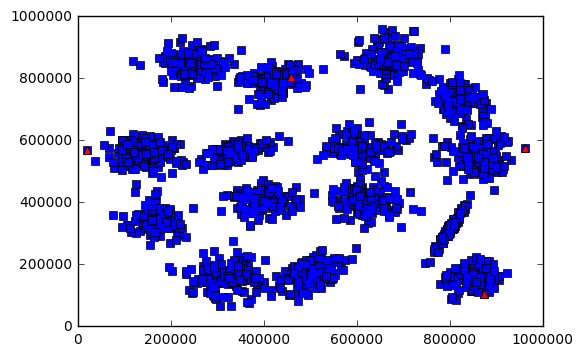

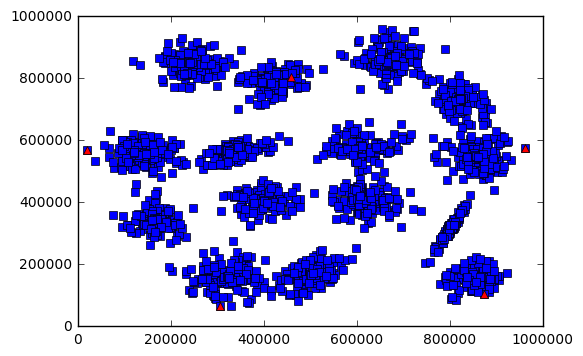

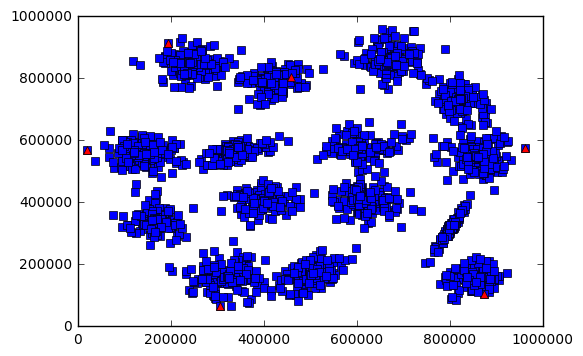

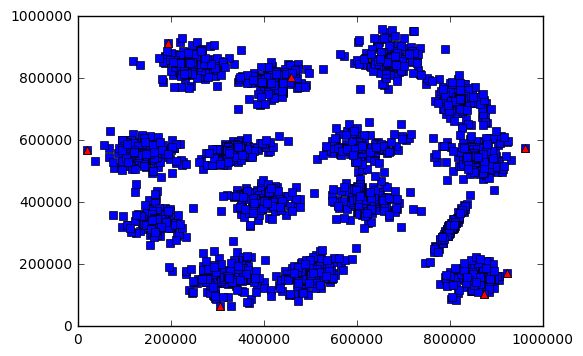

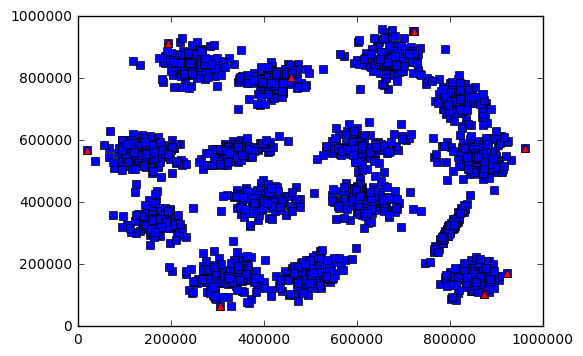

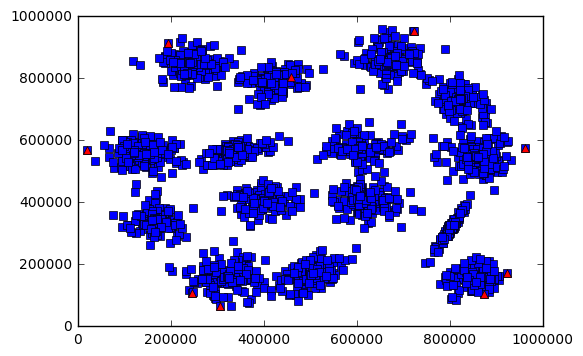

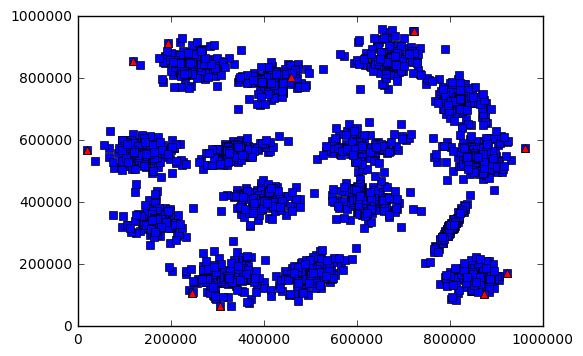

In [18]:
print("Initial cluster center : ",cluster1_center, "\n")
cluster_centers = [cluster1_center]
s1_map_clustered2 = initCluster(s1_map, num_features=2,num_clusters=10, reducer=reduceMaxSum,  cluster_centers=cluster_centers, visualize=True)

# Exemple d'utilisation de l'algorithme k-means++ sur nos données (version distribuée et initialisation reduceMaxAverage)

Initial cluster center :  (459328, 805961) 

Current cluster points : [(459328, 805961)]

 Cluster list :  [(459328, 805961), (874672, 104851)]

 New cluster point : (874672, 104851)
Current cluster points : [(459328, 805961), (874672, 104851)]

 Cluster list :  [(459328, 805961), (874672, 104851), (19835, 570290)]

 New cluster point : (19835, 570290)
Current cluster points : [(459328, 805961), (874672, 104851), (19835, 570290)]

 Cluster list :  [(459328, 805961), (874672, 104851), (19835, 570290), (961951, 577029)]

 New cluster point : (961951, 577029)
Current cluster points : [(459328, 805961), (874672, 104851), (19835, 570290), (961951, 577029)]

 Cluster list :  [(459328, 805961), (874672, 104851), (19835, 570290), (961951, 577029), (306042, 66361)]

 New cluster point : (306042, 66361)
Current cluster points : [(459328, 805961), (874672, 104851), (19835, 570290), (961951, 577029), (306042, 66361)]

 Cluster list :  [(459328, 805961), (874672, 104851), (19835, 570290), (961951, 

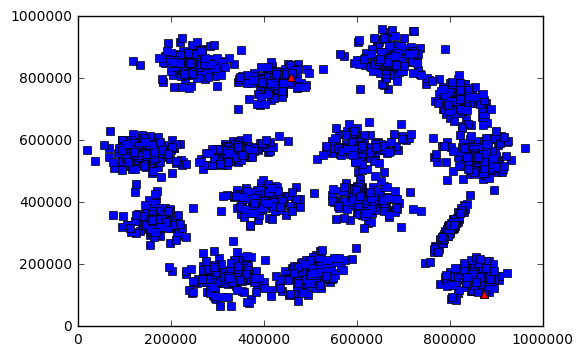

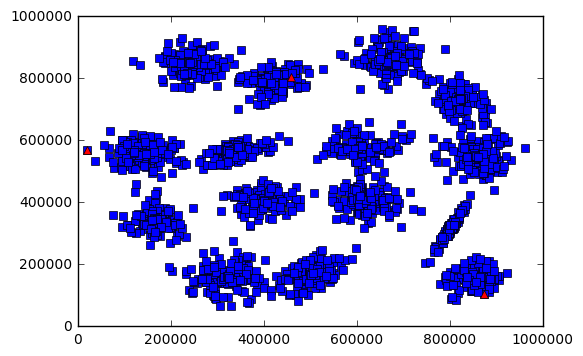

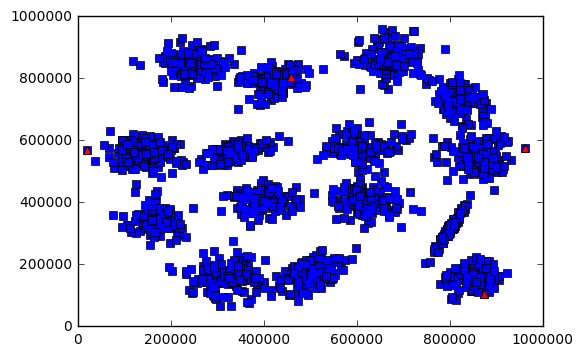

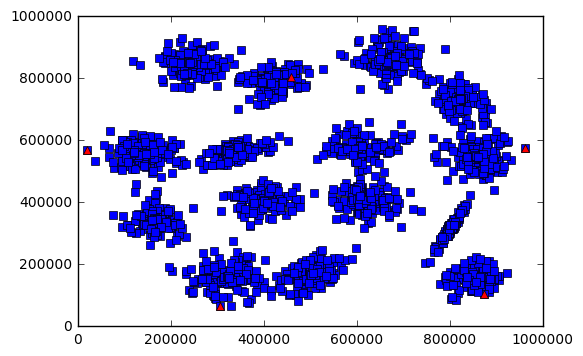

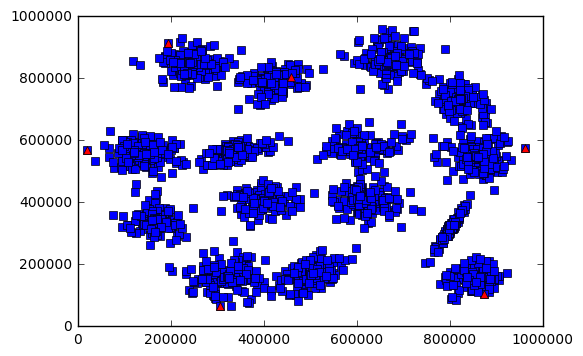

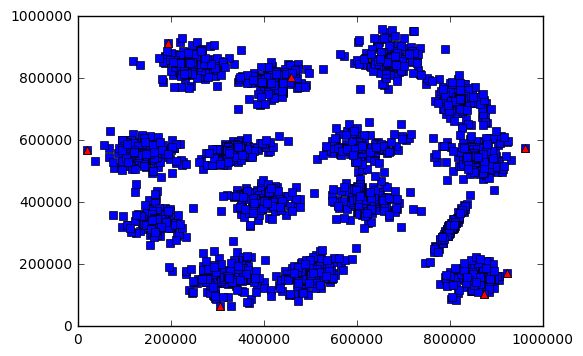

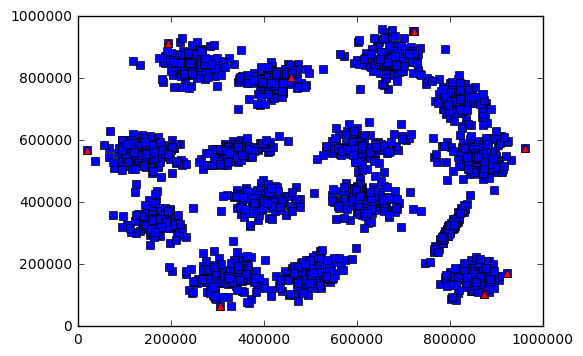

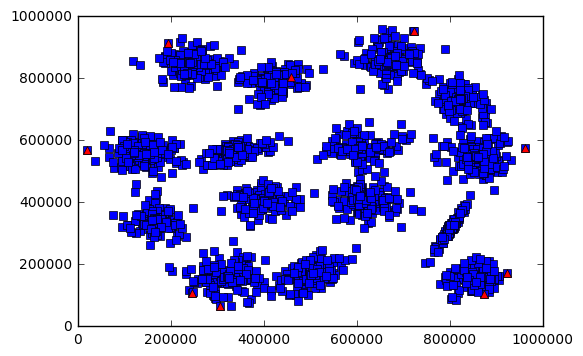

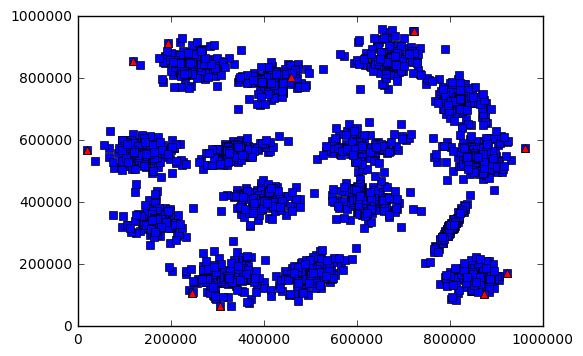

In [19]:
print("Initial cluster center : ",cluster1_center, "\n")
cluster_centers = [cluster1_center]
s1_map_clustered2 = initCluster(s1_map, num_features=2,num_clusters=10, reducer=reduceMaxAverage,  cluster_centers=cluster_centers, visualize=True)

# Exemple d'utilisation de l'algorithme k-means++ sur nos données (version distribuée et initialisation reduceMaxWithRandomSum)

Initial cluster center :  (459328, 805961) 

Current cluster points : [(459328, 805961)]

 Cluster list :  [(459328, 805961), (615239, 317684)]

 New cluster point : (615239, 317684)
Current cluster points : [(459328, 805961), (615239, 317684)]

 Cluster list :  [(459328, 805961), (615239, 317684), (684091, 842566)]

 New cluster point : (684091, 842566)
Current cluster points : [(459328, 805961), (615239, 317684), (684091, 842566)]

 Cluster list :  [(459328, 805961), (615239, 317684), (684091, 842566), (659046, 930099)]

 New cluster point : (659046, 930099)
Current cluster points : [(459328, 805961), (615239, 317684), (684091, 842566), (659046, 930099)]

 Cluster list :  [(459328, 805961), (615239, 317684), (684091, 842566), (659046, 930099), (684091, 842566)]

 New cluster point : (684091, 842566)
Current cluster points : [(459328, 805961), (615239, 317684), (684091, 842566), (659046, 930099), (684091, 842566)]

 Cluster list :  [(459328, 805961), (615239, 317684), (684091, 842566)

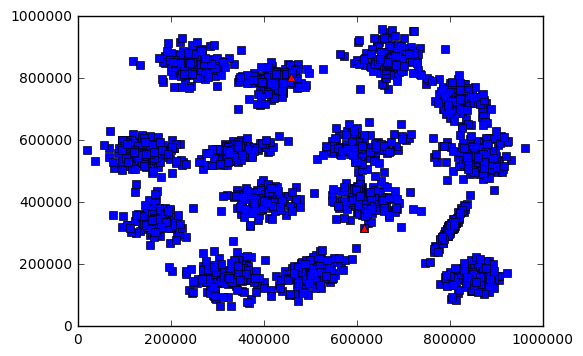

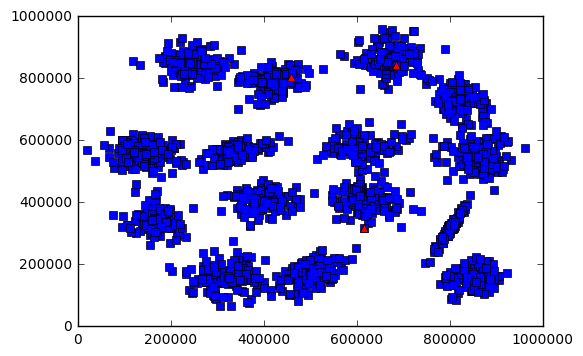

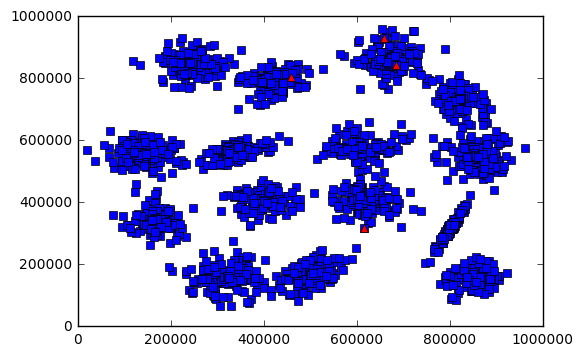

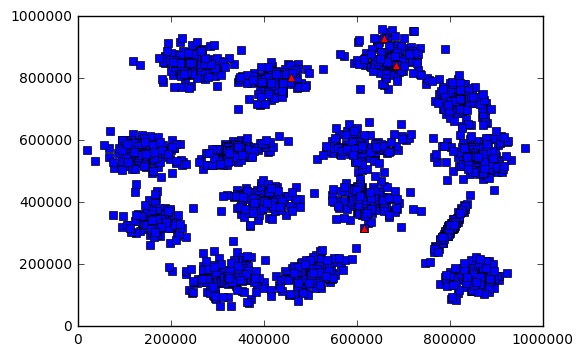

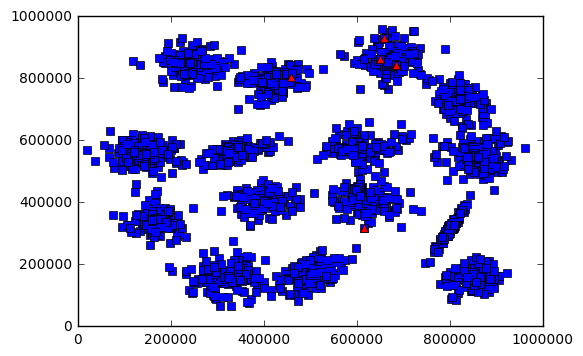

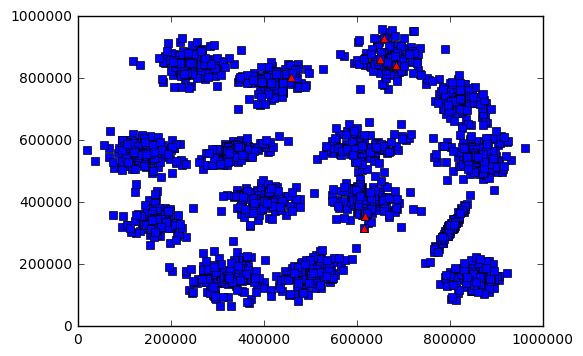

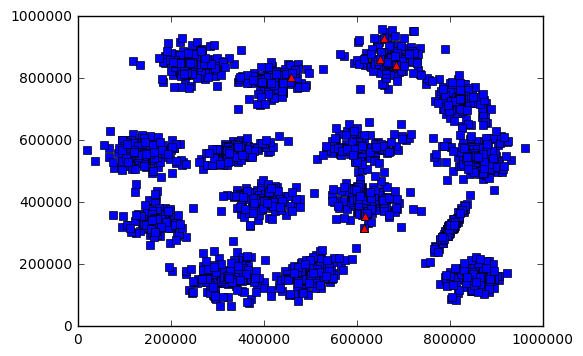

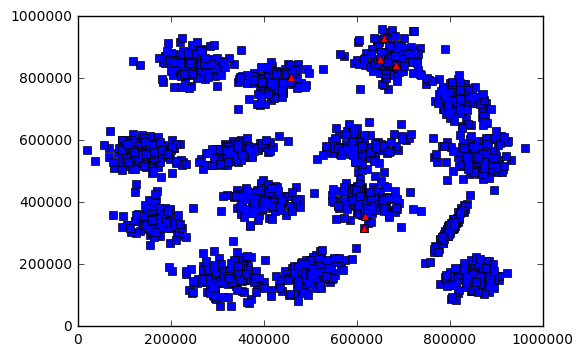

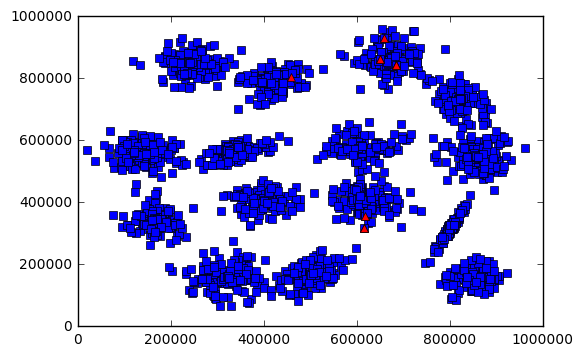

In [20]:
print("Initial cluster center : ",cluster1_center, "\n")
cluster_centers = [cluster1_center]
s1_map_clustered2 = initCluster(s1_map, num_features=2,num_clusters=10, reducer=reduceMaxWithRandomSum,  cluster_centers=cluster_centers, visualize=True)

# Algorithme kmeans et visualisation toutes les dix itérations

In [21]:
def distance(x1, x2):
    sum = 0
    for i in range(len(x1)):
        sum += (x2[i] - x1[i]) ** 2
    
    distance_result = sqrt(sum)
    
    return distance_result


#L X Y X1 Y1 D1 X2 Y2 D2 X3 Y3 D3
#0 1 2 3  4  5  6  7  8  9  10 11
def computeCluster(num_features, num_clusters):
    def map_cluster(row):
        
        #print("====== \n Map compute cluster distance")
        index_coord = [index for index in range(1,num_features + 1)]
        #print("index coords :", index_coord)
        
        coords_value = [row[index] for index in index_coord]
            
        indexes_clusters = [[index_cluster*num_features + index_features + index_cluster for index_features in range(0,num_features)] for index_cluster in range(1, num_clusters+ 1)]
        #print("index centers initial : ", indexes_clusters)
        
        indexes_distance = [index_cluster*num_features + index_cluster - 1 for index_cluster in range(2, num_clusters+ 2)]
        #print("indexes distance : ", indexes_distance)
        
        cluster_distances = []
        
        for cluster_coord_idx in indexes_clusters :
            
            coords_cluster = [row[index] for index in cluster_coord_idx]
            
            distance_cluster = distance(coords_value, coords_cluster)
            #print("Coord cluster ", coords_cluster)
            #print("Coord value ", coords_value)
            #print("Distance : ", distance_cluster)
            
            cluster_distances.append(distance_cluster)
            
        #print("Cluster distance array ", cluster_distances)
        
        index_max = np.argmin(cluster_distances) + 1
        #print("Index min : ", index_max)
        row_list = list(row)
        row_list[0] = index_max
        
        row = tuple(row_list)
        
        #print("========")
        
        return row
    return map_cluster
    
def formatDataReduce(num_features, num_clusters):
    def map_format(row):
        cluster = row[0]
        #indexes_clusters = [cluster * num_features + index_features + cluster for index_features in range(0,num_features)]
        indexes_coords = [index for index in range(1,num_features + 1)]
        
        coords_value = [row[index] for index in indexes_coords]
        #coords_cluster = [row[index] for index in indexes_clusters]
        
        return (cluster, (coords_value,1))
    return map_format

def reduceComputeCenter(num_features):
    def reduce_center(x1,x2):
        
        #print("X1 ", x1)
        #print("X2", x2)
        
        
        coords_x1 = x1[0]
        coords_x2 = x2[0]
        
        #print("Coords x1 ", coords_x1)
        #print("Coords x2", coords_x2)
        coords_sum = [coords_x1[i] + coords_x2[i] for i in range(0, num_features)]
        
        #print("Sum of coords", coords_sum)
        
        x1_num = x1[1]
        x2_num = x2[1]
        
        return tuple([coords_sum, x1_num + x2_num])
    return reduce_center

def updateClusterCoords(num_features, num_clusters, reduce):
    def map_update_cluster(row):
        
        #print("Reduce : ", reduce)
        indexes_clusters = [[index_cluster*num_features + index_features + index_cluster for index_features in range(0,num_features)] for index_cluster in range(1, num_clusters+ 1)]
        
        #print("index centers : ", indexes_clusters)
        
        num_cluster_real = len(reduce)
        for cluster in range(0,num_cluster_real):
            new_coordinates = reduce[cluster][1]
            cluster_center_indexes = indexes_clusters[cluster]
            
            for i in range(len(cluster_center_indexes)):
                row_list = list(row)
                row_list[cluster_center_indexes[i]] = new_coordinates[i]
                row = tuple(row_list)
        
        return row
            
        
        
    return map_update_cluster

def getRandomColor():
    return '#{:06x}'.format(randint(0, 0xffffff))    
    
def drawKmeans(data, cluster_centers, colorlist):
    datalist = data.collect()
    plt.figure()
    
    dict_point = {}
    
    for point in datalist:
        cluster = point[0]
        pointdict = dict_point.get(cluster, {})
        pointlist = pointdict.get("points",[])
        pointdict["color"] = colorlist[cluster - 1]
        
        pointlist.append([point[1],point[2]])
        pointdict["points"] = pointlist
        
        dict_point[cluster] = pointdict
    
    #print("Dict point ", dict_point)
    
    for key in dict_point:
        pointlist = dict_point[key]["points"]
        color = dict_point[key]["color"]
        
        x = [item[0] for item in pointlist]
        y = [item[1] for item in pointlist]
        
        #print("Color ", color)
        #print("X ", x)
        #print("Y ",y)
        plt.scatter(x,y,color = color, marker="s")
        
    x_clusters = [point[0] for point in cluster_centers]
    y_clusters = [point[1] for point in cluster_centers]
    
    plt.plot(x_clusters, y_clusters, 'r^')
    
def kmeans(data, cluster_centers, num_iterations, num_features, visualize=False):
    if visualize:
        colorlist = [getRandomColor() for i in range(len(cluster_centers))]

    num_clusters = len(cluster_centers)
    #print("Num clusters :", num_clusters, "\n")
    
    #Cluster is first in the tuple
    data = data.map(lambda x : (-1,) + x)
    
    #print("Data with empty cluster", data.take(3), "\n")
    data = data.map(computeCluster(num_features, num_clusters))
    
    #print("Data with cluster", data.take(3), "\n")
    
    for it in range(num_iterations):
        dataReduce = data.map(formatDataReduce(num_features, num_clusters))
        #print("Data prepared for the reduce :", dataReduce.take(3), "\n")
        
        reduce = dataReduce.reduceByKey(reduceComputeCenter(num_features))
        collect = reduce.collect()
        #print("Collect : ", collect)
        
        #COMPUTE AVERAGE
        reduce_list = []
        
        #tuple reduce : ( 1, ([2,3,4], 112))
        for tuple_reduce in reduce.collect():
            cluster = tuple_reduce[0]
            
            tuple_value = tuple_reduce[1]
            
            coord_list = tuple_value[0]
            
            num_point = tuple_value[1]
            
            for i in range(0,num_features):
                coord_list[i] = coord_list[i] / num_point
            
            reduce_list.append( (cluster, coord_list) )
        
        #print("Result of reduce : ", reduce_list, "\n")
        
        
        #reduce list :  (1, [2,3,4])
        data = data.map(updateClusterCoords(num_features, num_clusters, reduce_list))
        #print("Result of map update coords :", data.take(3), "\n")
        
        data = data.map(computeCluster(num_features, num_clusters))
        #print("Data with updated cluster", data.take(3), "\n")
        
        if visualize and (it %10 == 0):
            cluster_centers = []
            for tuple_reduce in reduce_list:
                cluster_centers.append([tuple_reduce[1][0],tuple_reduce[1][1]])
            
        
            drawKmeans(data = data, cluster_centers=cluster_centers, colorlist=colorlist)
             
        print("--------------")

        
    return data

***Exemple d'utilisation de l'initialisation avec la stratégie reduceMax et 30 itérations de kmeans.***

Initial cluster center :  (791983, 298565) 

Current cluster points : [(791983, 298565)]

 Cluster list :  [(791983, 298565), (118590, 857150)]

 New cluster point : (118590, 857150)
Current cluster points : [(791983, 298565), (118590, 857150)]

 Cluster list :  [(791983, 298565), (118590, 857150), (722404, 952207)]

 New cluster point : (722404, 952207)
Current cluster points : [(791983, 298565), (118590, 857150), (722404, 952207)]

 Cluster list :  [(791983, 298565), (118590, 857150), (722404, 952207), (196795, 190277)]

 New cluster point : (196795, 190277)
Current cluster points : [(791983, 298565), (118590, 857150), (722404, 952207), (196795, 190277)]

 Cluster list :  [(791983, 298565), (118590, 857150), (722404, 952207), (196795, 190277), (452457, 597461)]

 New cluster point : (452457, 597461)
Current cluster points : [(791983, 298565), (118590, 857150), (722404, 952207), (196795, 190277), (452457, 597461)]

 Cluster list :  [(791983, 298565), (118590, 857150), (722404, 952207)

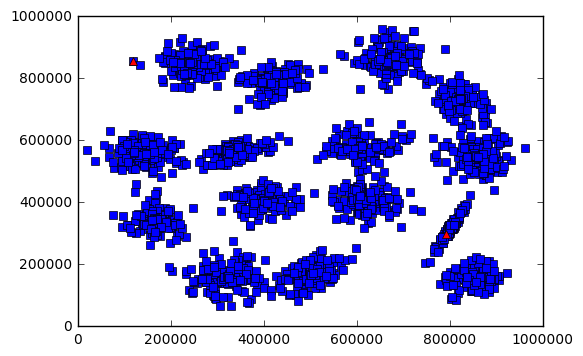

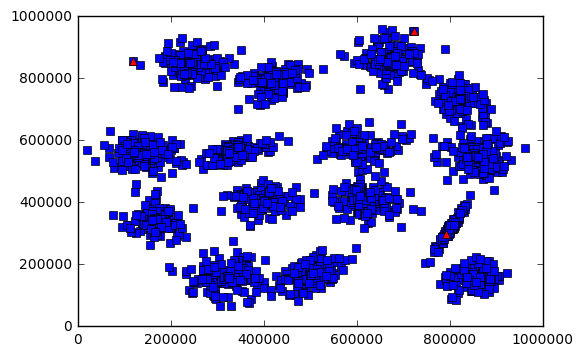

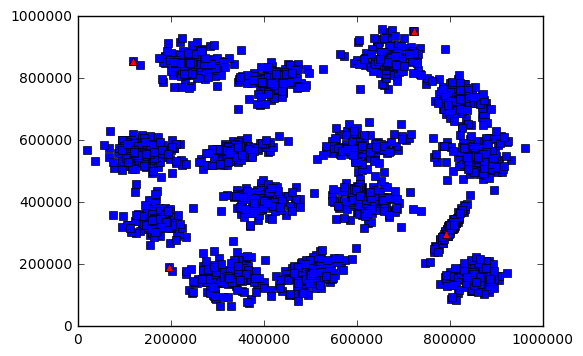

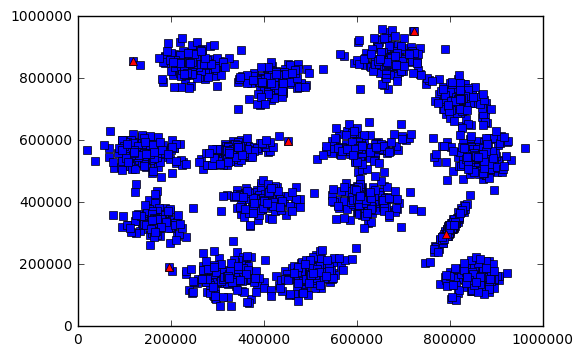

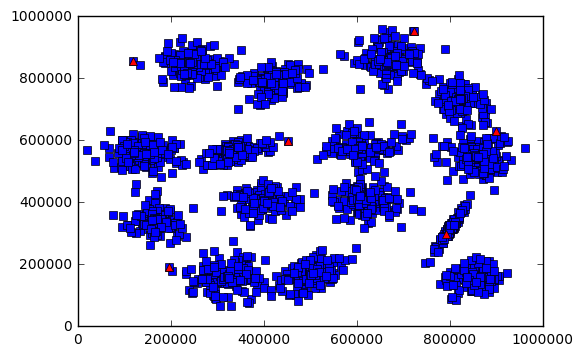

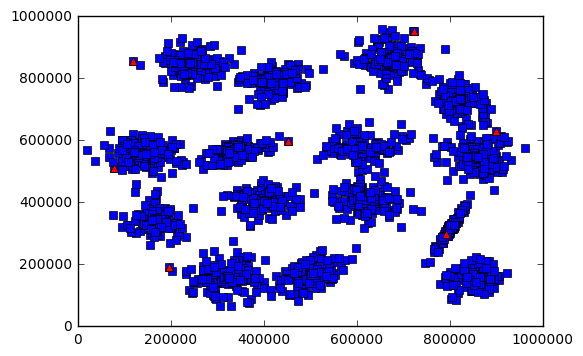

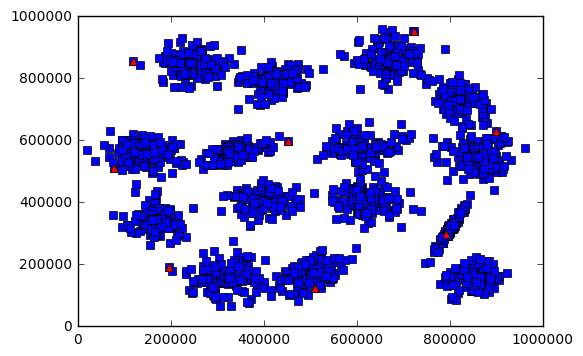

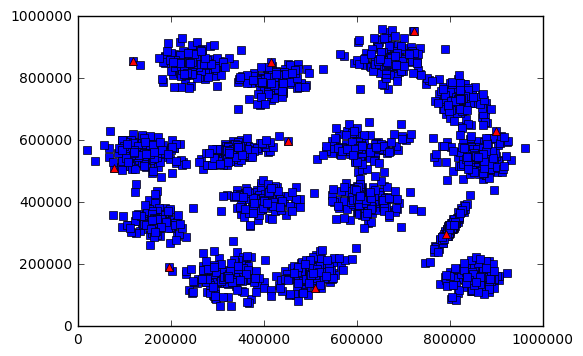

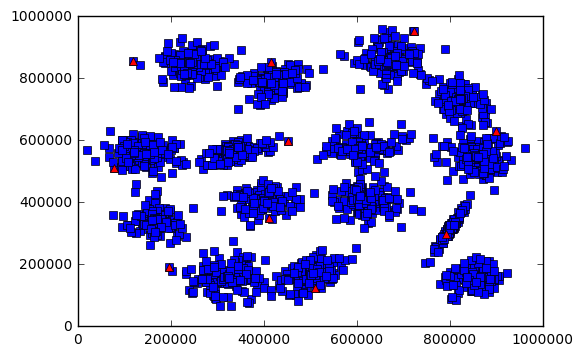

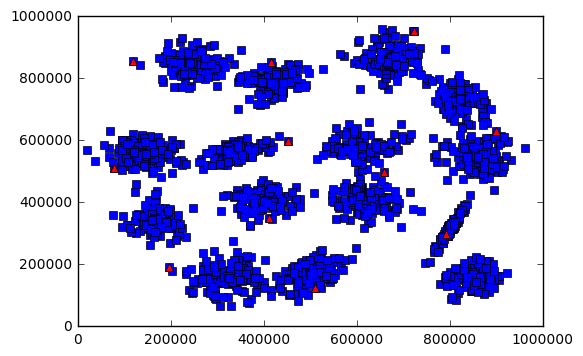

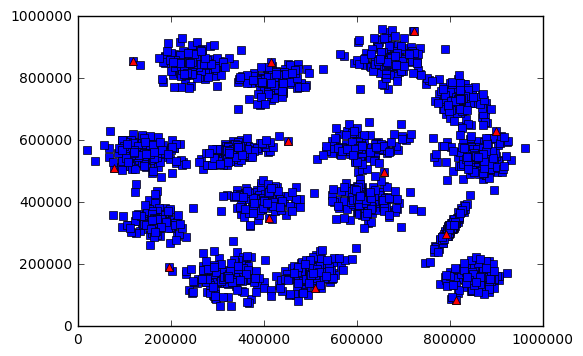

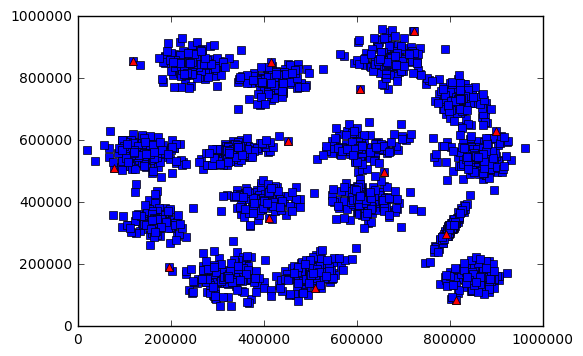

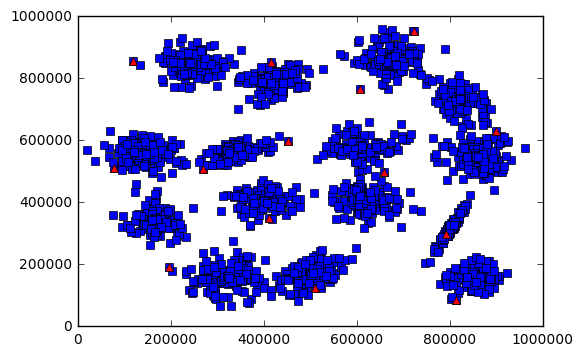

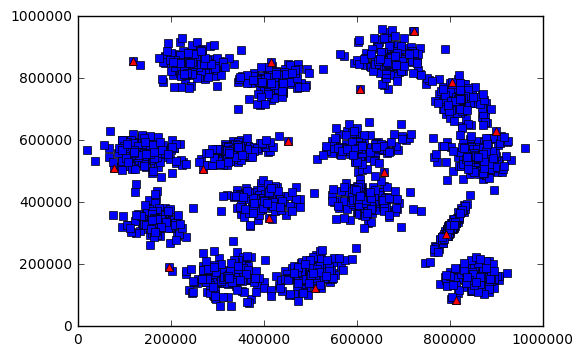

In [22]:
cluster1_center = s1.takeSample(False, 1)[0]
cluster_centers = [cluster1_center]
print("Initial cluster center : ",cluster1_center, "\n")


s1_map = s1.map(lambda x : x + cluster1_center)
s1_map_clustered, cluster_centers = initCluster(s1_map, num_features=2,num_clusters=15, reducer=reduceMax, cluster_centers=cluster_centers, visualize=True)

--------------
--------------
--------------
--------------
--------------
--------------
--------------
--------------
--------------
--------------
--------------
--------------
--------------
--------------
--------------
--------------
--------------
--------------
--------------
--------------
--------------
--------------
--------------
--------------
--------------
--------------
--------------
--------------
--------------
--------------


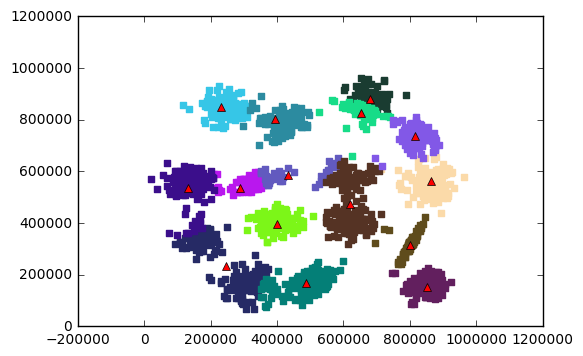

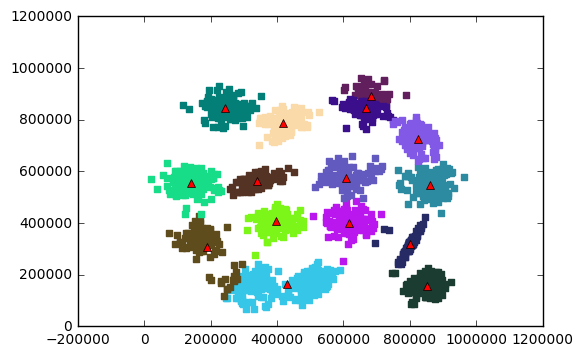

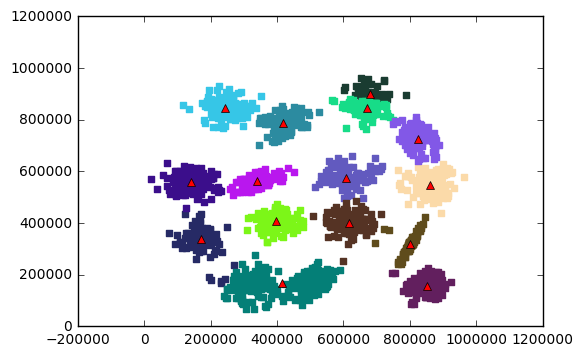

In [23]:
kmeans_result = kmeans(s1_map_clustered, cluster_centers, num_iterations=30, num_features=2, visualize=True)

***En utilisant cet algorithme avec une initialisation reduceMaxWithRandom (version distribuée), nous obtenons de moins bons résultats que l'initialisation reduceMax. On peut voir qu'il y a de plus petit cluster moins bien répartis sur les données. ***

Initial cluster center :  (791983, 298565) 

Current cluster points : [(791983, 298565)]

 Cluster list :  [(791983, 298565), (608601, 418450)]

 New cluster point : (608601, 418450)
Current cluster points : [(791983, 298565), (608601, 418450)]

 Cluster list :  [(791983, 298565), (608601, 418450), (650661, 861267)]

 New cluster point : (650661, 861267)
Current cluster points : [(791983, 298565), (608601, 418450), (650661, 861267)]

 Cluster list :  [(791983, 298565), (608601, 418450), (650661, 861267), (684091, 842566)]

 New cluster point : (684091, 842566)
Current cluster points : [(791983, 298565), (608601, 418450), (650661, 861267), (684091, 842566)]

 Cluster list :  [(791983, 298565), (608601, 418450), (650661, 861267), (684091, 842566), (659046, 930099)]

 New cluster point : (659046, 930099)
Current cluster points : [(791983, 298565), (608601, 418450), (650661, 861267), (684091, 842566), (659046, 930099)]

 Cluster list :  [(791983, 298565), (608601, 418450), (650661, 861267)

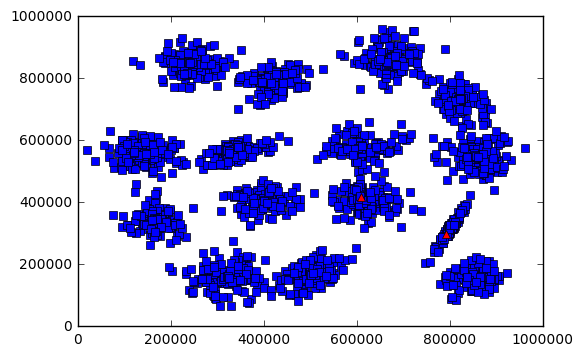

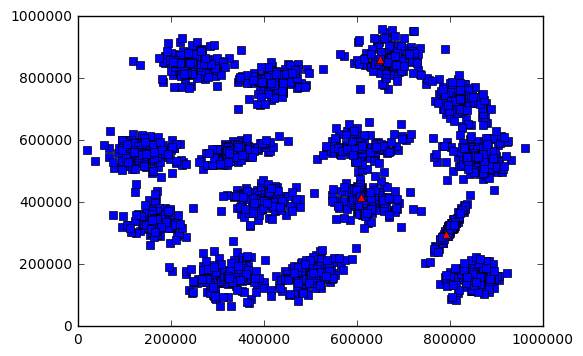

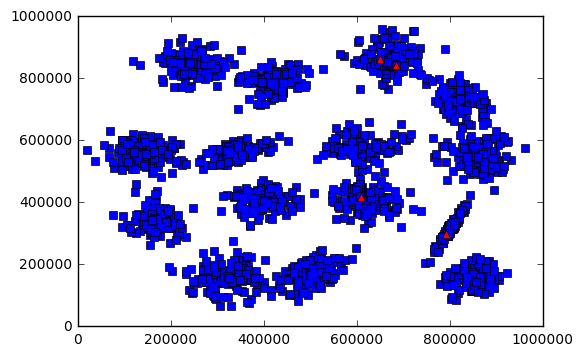

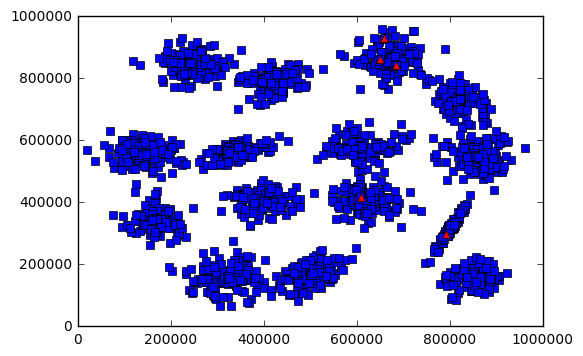

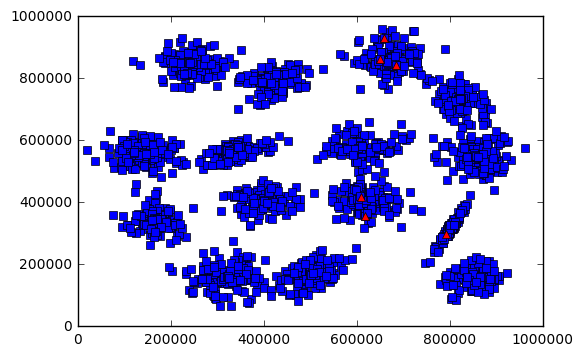

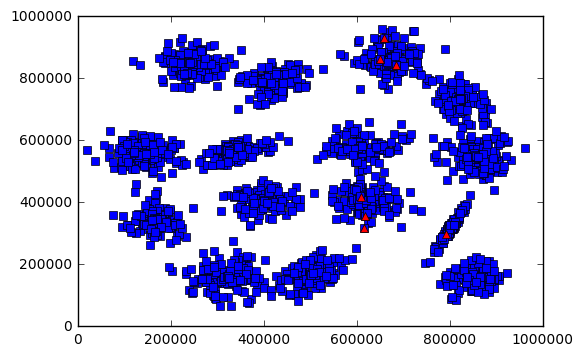

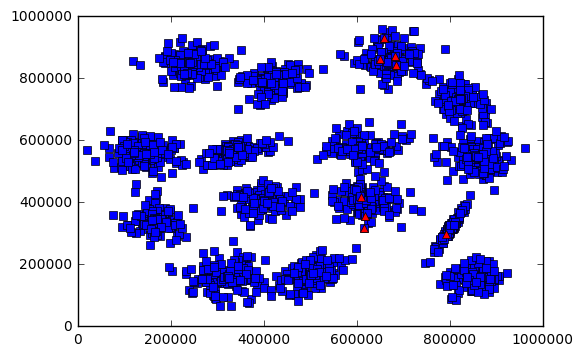

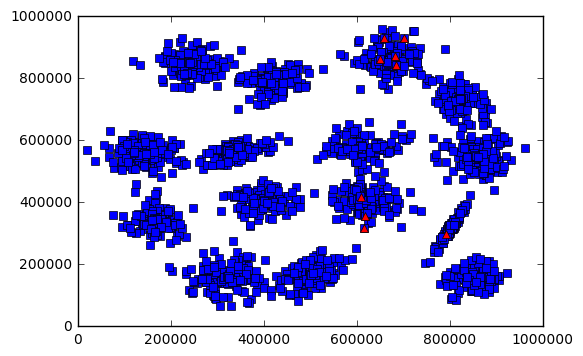

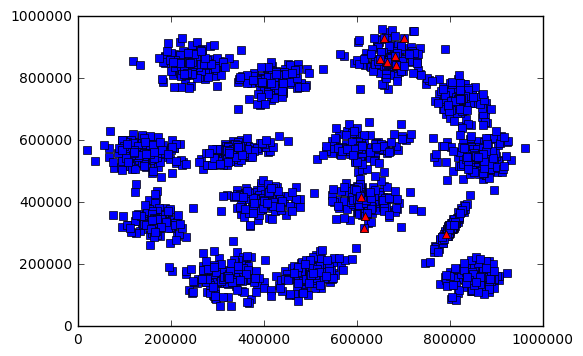

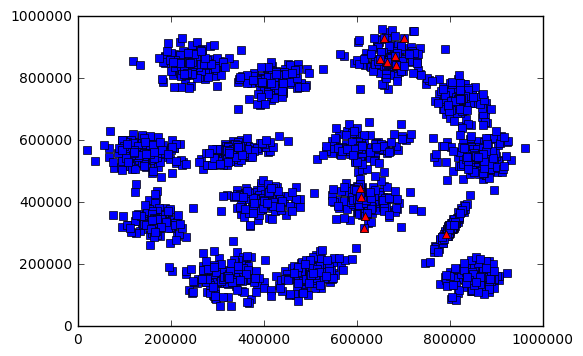

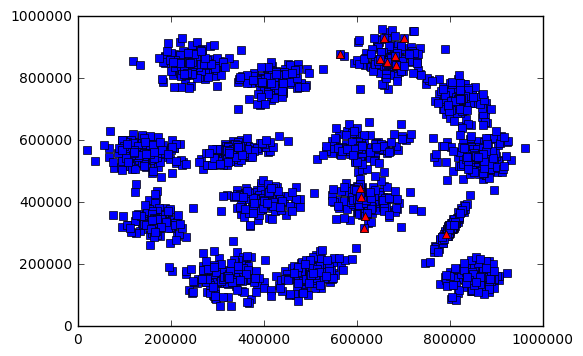

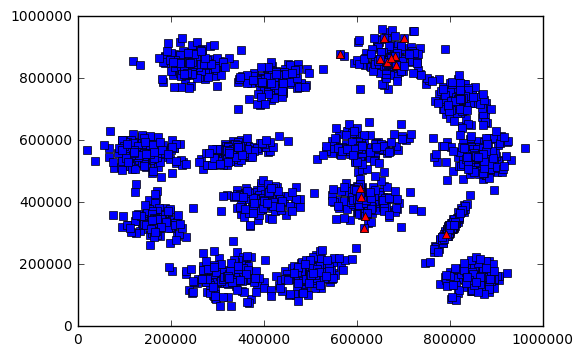

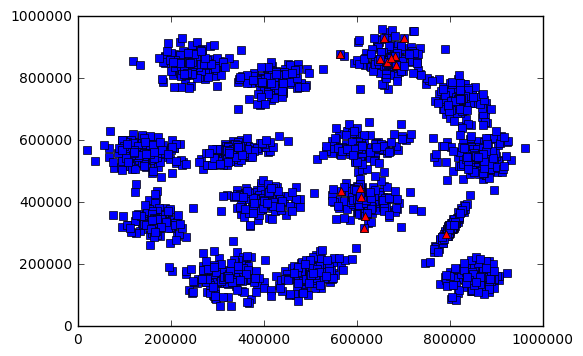

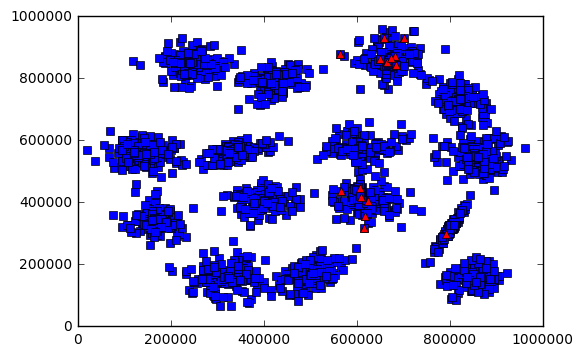

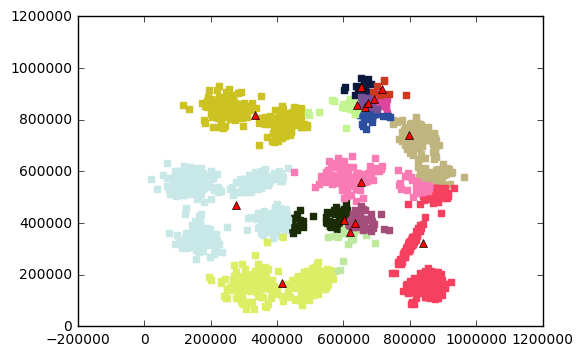

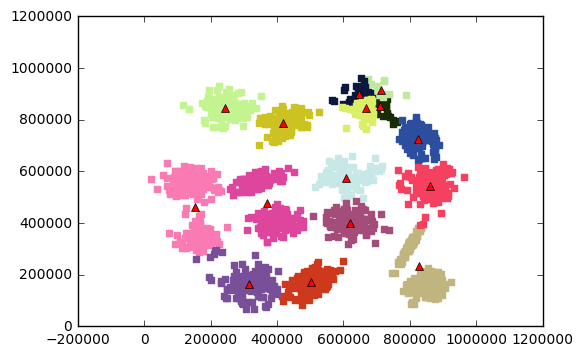

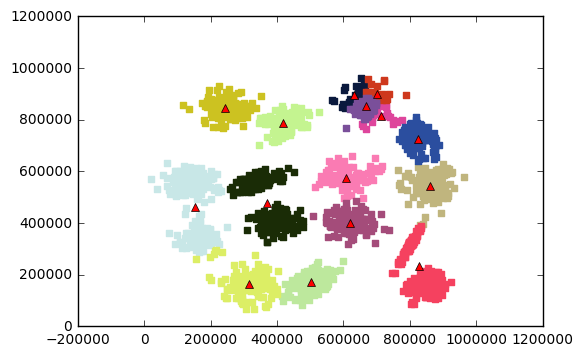

In [24]:
cluster_centers = [cluster1_center]
print("Initial cluster center : ",cluster1_center, "\n")


s1_map = s1.map(lambda x : x + cluster1_center)
s1_map_clustered, cluster_centers = initCluster(s1_map, num_features=2,num_clusters=15, reducer=reduceMaxWithRandom, cluster_centers=cluster_centers, visualize=True)
kmeans_result = kmeans(s1_map_clustered, cluster_centers, num_iterations=30, num_features=2, visualize=True)

*** En initialisant avec la stratégie k-means++ non optimisé pour être distribué correctement ( mais exacte sur le plan théorique), le résultat est correct mais il peut mettre du temps à tourner et à nous fournir les résultats finaux. Il n'est pas scalable si on augmente le nombre de points (en desactivant les visualisations) ***

Initial cluster center :  (791983, 298565) 

Current cluster points : [(791983, 298565)]
Data zip [(0, (665845, 557965, 791983, 298565, 288442.637354466)), (1, (597173, 575538, 791983, 298565, 338622.1771074659)), (2, (618600, 551446, 791983, 298565, 306611.26014874276))]
Data zip map [(0, 288442.637354466), (1, 338622.1771074659), (2, 306611.26014874276)]
Data to extract max dist [288442.637354466, 338622.1771074659, 306611.26014874276]
Full cumulative sum is  :  1052620152.3421695
Data zip map normalized  [(0, 0.00027402348008695877), (1, 0.00032169456033499143), (2, 0.0002912838591076815)]
[(0, 0.00027402348008695877), (1, 0.00032169456033499143), (2, 0.0002912838591076815)]
[0, 1, 2]
[0.00027402348008695877, 0.00032169456033499143, 0.0002912838591076815]
0.999999999999999
Draw :  0.5290305522127188
Cumsum 0 0.000274023480087
Best point  [(1381, (265246, 889333, 791983, 298565, 791491.4383573583))]
(265246, 889333)

 Cluster list :  [(791983, 298565), (265246, 889333)]

 New cluster

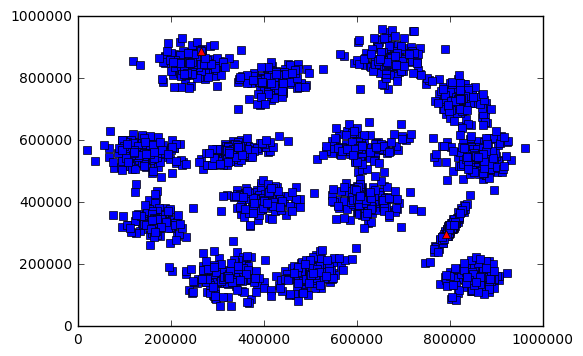

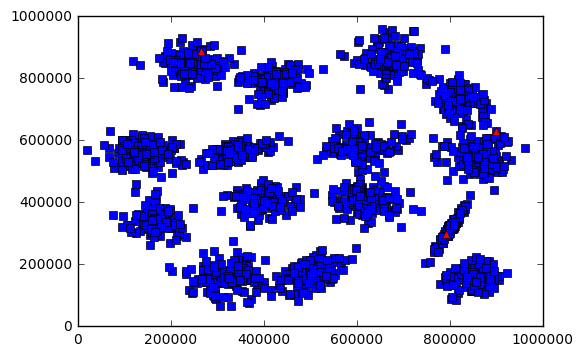

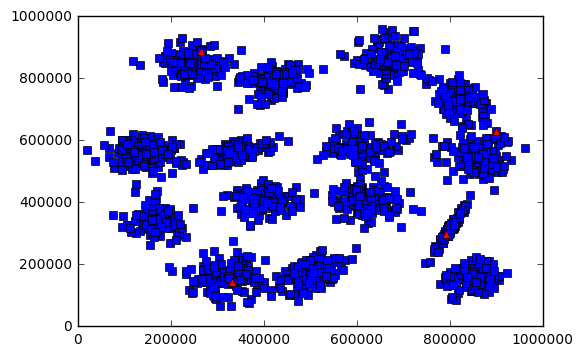

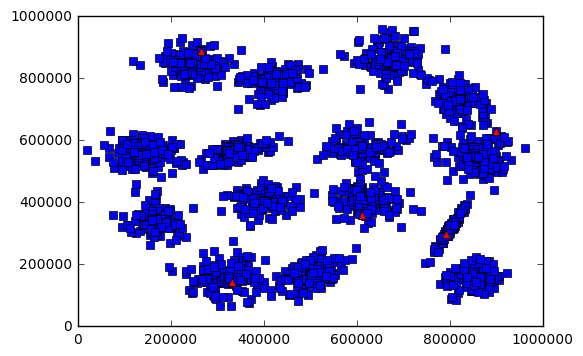

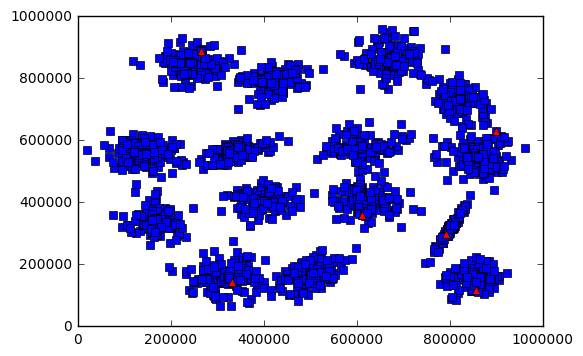

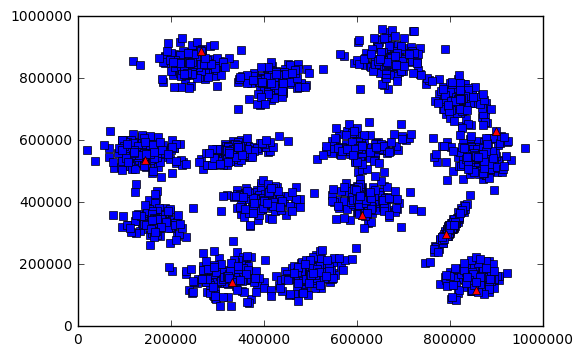

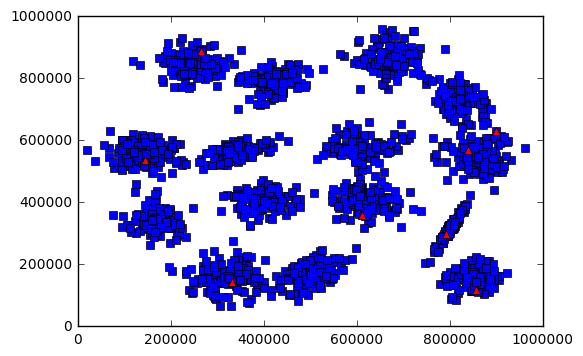

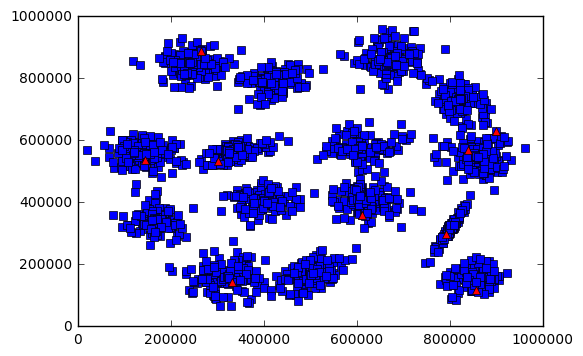

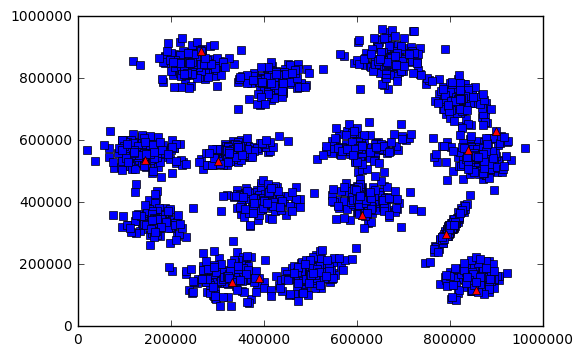

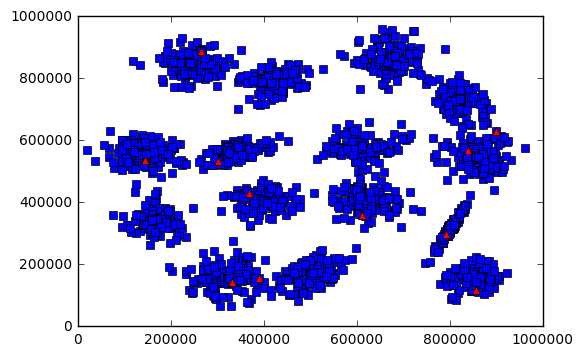

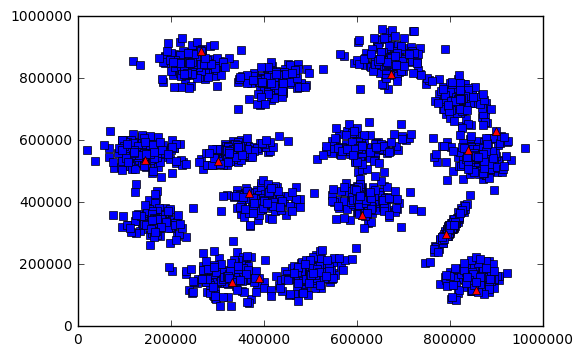

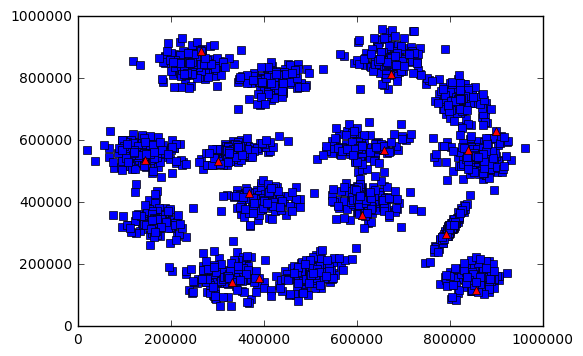

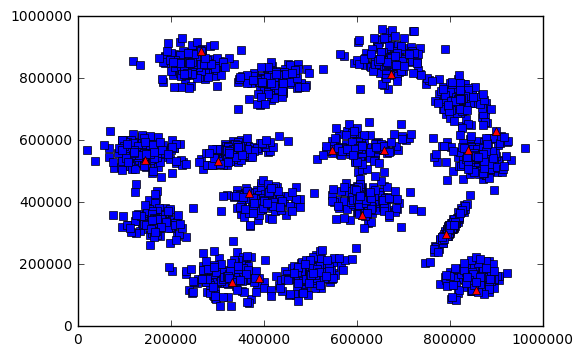

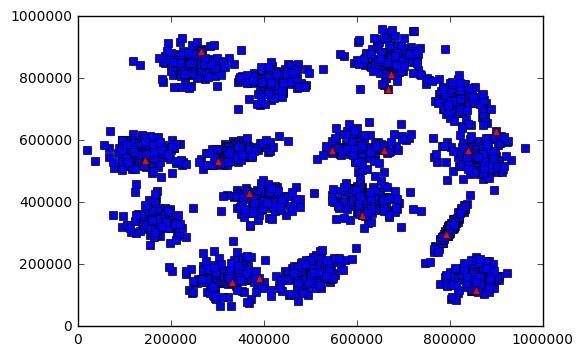

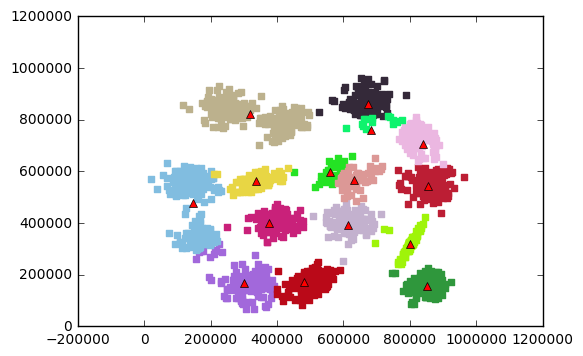

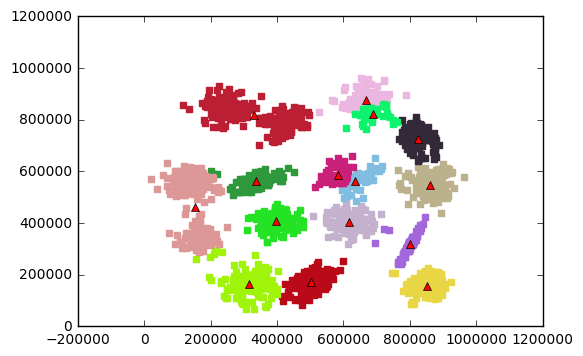

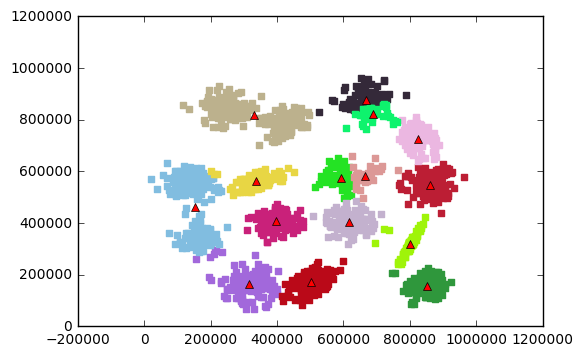

In [25]:
cluster_centers = [cluster1_center]
print("Initial cluster center : ",cluster1_center, "\n")


s1_map = s1.map(lambda x : x + cluster1_center)
s1_map_clustered, cluster_centers = initCluster(s1_map, num_features=2,num_clusters=15, reducer=reduceMaxWithRandom, cluster_centers=cluster_centers, distributed=False, visualize=True)
kmeans_result = kmeans(s1_map_clustered, cluster_centers, num_iterations=30, num_features=2, visualize=True)

# Conclusion

- En définitive, l'algorithme exact k-means++ n'est pas optimal pour être distribué correctement sous Spark, il nous oblige à itérer sur l'ensemble des données, ce qui engendre une complexité temporelle proportionelle à la taille des donnée.
- C'est pourquoi nous avons été amené, dans le cas distribué, à implémenter des initialisations alternatives (autres qu'une initialisation "probabiliste" des centres) qui ne sont certes pas parfaites mais qui, pour certaines d'entre elles, nous offrent des résultats globalement satisfaisants en termes de qualité des centres et clusters finaux et vitesse de convergence, tout en étant scalable avec la taille des données.
- L'évaluation de méthode de clustering n'est pas un exercice facile, mais à partir de simples visualisations, on se rend compte que c'est la stratégie reduceMax qui nous donne les meilleurs résultats
- La tentative de distribution de kmeans++ à travers un mode de "tournoi" n'a pas donné de résultats satisfaisants (problème algorithmique ou bien de code ?)


# Pour aller plus loin

On peut encore améliorer beaucoup de choses sur notre projet, il est toujours possible d'aller plus loin :
- On aurait pu essayer de tester les méthodes de caching de Spark pour voir comment optimiser nos performances
- On aurait pu tester d'autres librairies de calcul distribué que Spark pour comparer les performances
- On a testé notre algorithme surtout en local, mais il peut être interessant de voir sur un cluster et d'essayer de repérer les points bloquants.
- On aurait peut être pu voir si il était possible d'utiliser des DataFrame Spark 